We load all the Python libraries necessary to run the code in this demo.

In [40]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_density, facet_wrap, theme, labs, element_blank, element_text,element_line,scale_y_continuous
from plotnine import geom_point, geom_text, theme, geom_line, scale_color_manual,scale_color_brewer
from textwrap import wrap
from sklearn.cluster import KMeans, DBSCAN

We start by loading our data. This dataset is composed of a mix of development-related indicators collated from the [Worldwide Governance Indicators (WGI) project](https://info.worldbank.org/governance/wgi/) at the World Bank (which provides single scores for several different governance indicators, including adherence to the rule of law, how well designed regulations are and how effective government in each country is) as well as from [Freedom House](https://freedomhouse.org/) (e.g indices relating to political freedoms) across 170 countries. The data relates to either 2019 or (if this was unavailable) the latest year no earlier than 2016. These 170 countries are those with a complete dataset - any country missing any data is excluded from the dataset.

The dataset indicators has from six categories:

- Economic fundamentals (e.g GDP, GDP per capita)

- Demographics (e.g total population, population density, urban population (% of total population)

- Freedom and Rights (e.g Civil liberties score, Political rights score)

- Governance (e.g WGI-GovernanceEffectiveness, WGI - RegulatoryQuality)

- Health and Education (e.g Literacy rate, adult total (% of people ages 15 and above), Current health expenditure (% of GDP))

- Infrastructure (e.g Fixed broadband subscriptions (per 100 people))



In [41]:
# Step 1: Load the data

# Consolidated indicators
development_indicators= pd.read_csv("development-indicators-latest.csv")

# Indicators grouped into categories
indicators=pd.read_csv("indicators-all.csv")

In [42]:
development_indicators.head()

country_code          country_name    region  \
0          AFG           Afghanistan      Asia   
1          AGO                Angola    Africa   
2          ALB               Albania    Europe   
3          ARE  United Arab Emirates      Asia   
4          ARG             Argentina  Americas   

                        sub_region  Current health expenditure (% of GDP)  \
0                    Southern Asia                               9.395727   
1               Sub-Saharan Africa                               2.549005   
2                  Southern Europe                               5.262714   
3                     Western Asia                               4.225904   
4  Latin America and the Caribbean                               9.624540   

   Current health expenditure per capita (current US$)  \
0                                          49.842609     
1                                          87.616768     
2                                         274.914093     
3                                        1817.347656     
4                                        1127.907227     

   Ease of doing business score (0 = lowest performance to 100 = best performance)  \
0                                           44.06497                                 
1                                           41.28838                                 
2                                           67.74847                                 
3                                           80.91489                                 
4                                           58.96151                                 

   Fertility rate, total (births per woman)  \
0                                     4.321   
1                                     5.442   
2                                     1.597   
3                                     1.387   
4                                     2.247   

   Fixed broadband subscriptions (per 100 people)  GDP (current US$)  ...  \
0                                        0.051741       1.929110e+10  ...   
1                                        0.374130       8.881570e+10  ...   
2                                       15.140735       1.527918e+10  ...   
3                                       31.174945       4.211423e+11  ...   
4                                       19.636106       4.454452e+11  ...   

   5-year average GDP per capita growth  WGI - VoiceandAccountability  \
0                             -0.351754                     -0.988032   
1                             -4.130519                     -0.777283   
2                              3.379925                      0.151805   
3                              1.490085                     -1.122036   
4                             -1.265739                      0.600435   

   WGI - Political StabilityNoViolence  WGI - GovernmentEffectiveness  \
0                            -2.649407                      -1.463875   
1                            -0.311101                      -1.117144   
2                             0.118570                      -0.061331   
3                             0.703494                       1.377221   
4                            -0.119978                      -0.086486   

   WGI - RegulatoryQuality  WGI - RuleofLaw  WGI - ControlofCorruption  \
0                -1.120555        -1.713527                  -1.401076   
1                -0.893871        -1.054343                  -1.054683   
2                 0.274380        -0.411179                  -0.528758   
3                 0.979325         0.840219                   1.106342   
4                -0.492753        -0.430726                  -0.071071   

   Political rights score  Civil liberties score  Population aged 0 - 40  
0                      13                     14                0.836893  
1                      10                     21                0.846341  
2                      27                     39                0.544419  
3  

In [10]:
indicators

indicator_category                                     indicator_name
0          Infrastructure     Mobile cellular subscriptions (per 100 people)
1          Infrastructure     Fixed broadband subscriptions (per 100 people)
2    Health and Education              Current health expenditure (% of GDP)
3    Health and Education  Current health expenditure per capita (current...
4    Health and Education            Life expectancy at birth, total (years)
5    Health and Education  Literacy rate, adult total (% of people ages 1...
6   Economic fundamentals                                  GDP (current US$)
7   Economic fundamentals                       GDP per capita (current US$)
8            Demographics  Population density (people per sq. km of land ...
9            Demographics                       Population growth (annual %)
10           Demographics                                  Population, total
11           Demographics           Urban population (% of total population)
12         Infrastructure   Individuals using the Internet (% of population)
13           Demographics           Fertility rate, total (births per woman)
14           Demographics                                 Land area (sq. km)
15         Infrastructure  Ease of doing business score (0 = lowest perfo...
16     Freedom and Rights                             Political rights score
17     Freedom and Rights                              Civil liberties score
18  Economic fundamentals                          5-year average GDP growth
19  Economic fundamentals               5-year average GDP per capita growth
20           Demographics                             Population aged 0 - 40
21             Governance                       WGI - VoiceandAccountability
22             Governance                WGI - Political StabilityNoViolence
23             Governance                      WGI - GovernmentEffectiveness
24             Governance                            WGI - RegulatoryQuality
25             Governance                                    WGI - RuleofLaw
26             Governance                          WGI - ControlofCorruption

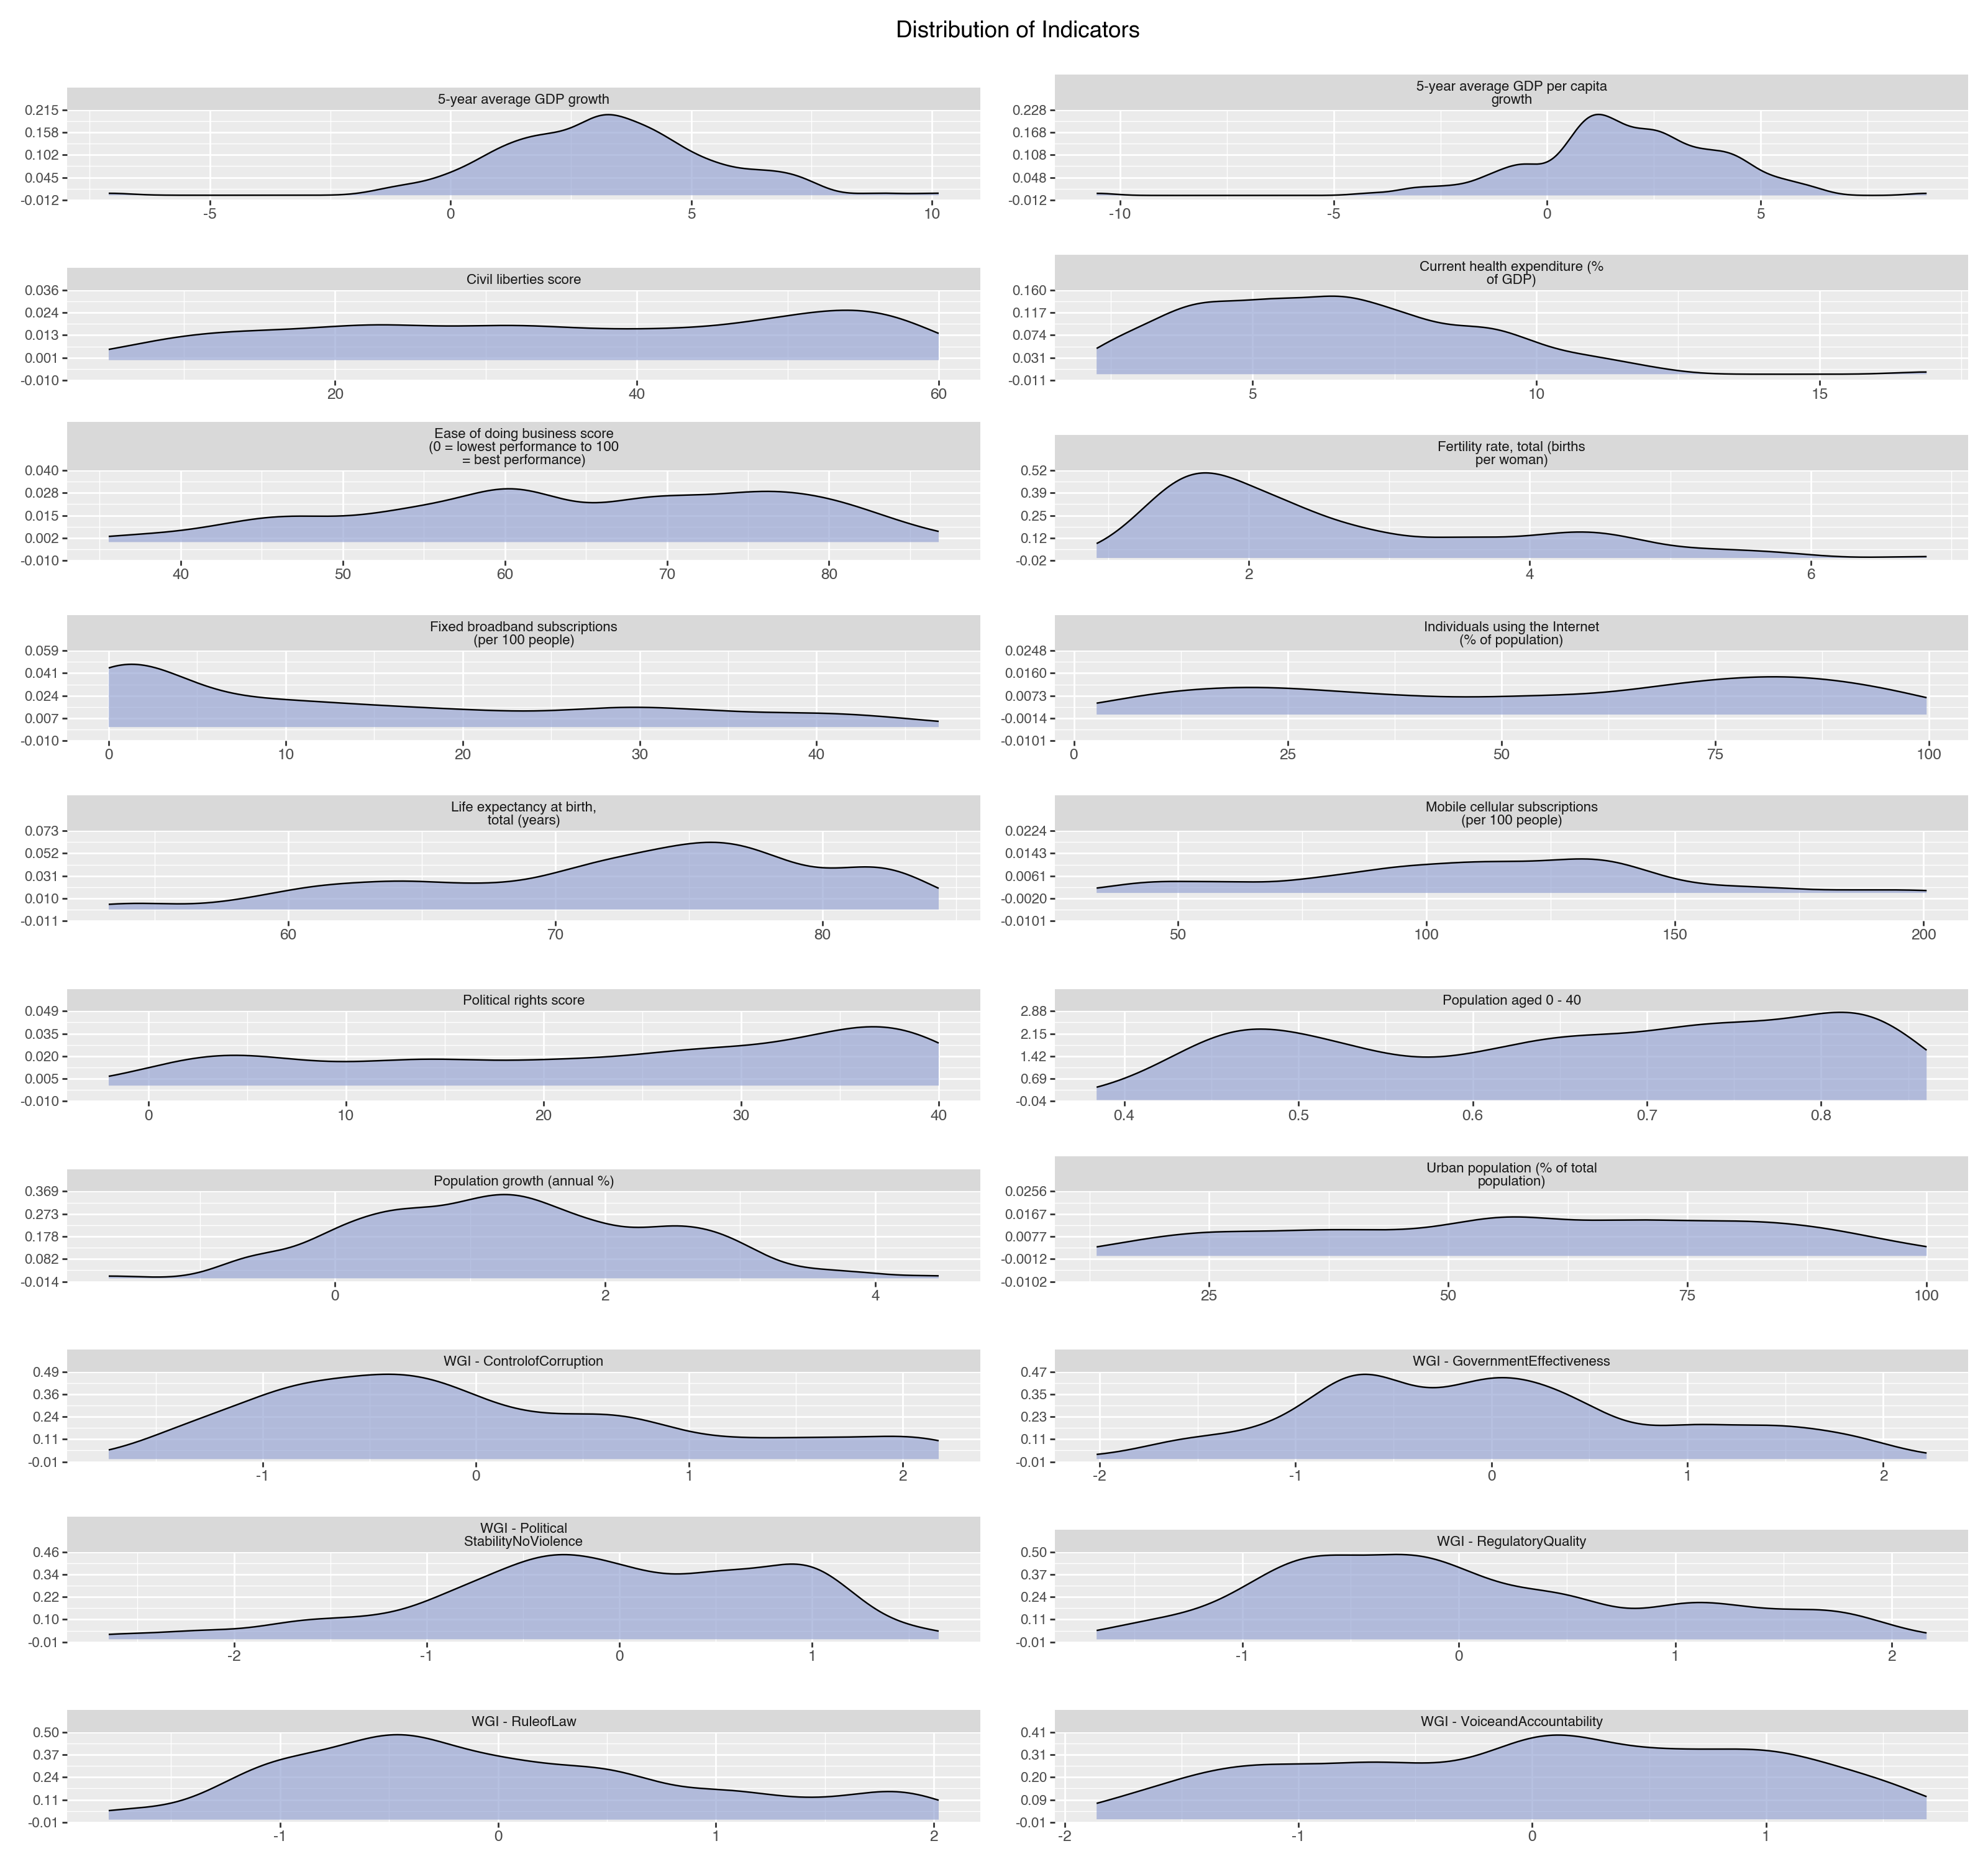

In [43]:



# Select numeric columns only
numeric_columns = development_indicators.select_dtypes(include="number")

# Reshape data for plotting
long_data = numeric_columns.melt(var_name="Indicator", value_name="Value").dropna()

# OPTIONAL: Standardize values for better comparison across indicators
# Uncomment the following line ONLY if scaling is necessary
#long_data["Value"] = (long_data["Value"] - long_data["Value"].mean()) / long_data["Value"].std()

# Further refine by excluding certain irrelevant indicators (if applicable)
excluded_indicators = ["country_code", "region", "sub_region"]
long_data = long_data[~long_data["Indicator"].isin(excluded_indicators)]

indicators_toplot_separately=['Current health expenditure per capita (current US$)',
 'GDP (current US$)',
 'GDP per capita (current US$)',
 'Land area (sq. km)',
 'Population density (people per sq. km of land area)',
 'Population, total']

# Plot
(
    ggplot(long_data[~long_data["Indicator"].isin(indicators_toplot_separately)], aes(x='Value'))
    + geom_density(fill='#98A6D4', alpha=0.7, adjust=0.7)  # Adjust the kernel density bandwidth for better smoothing
    + facet_wrap(
        '~Indicator',
        scales='free',  # Allow free scaling for both axes
        ncol=2,
        labeller=lambda x: "\n".join(wrap(x, 30))  # Wrap long indicator names
    )
    + labs(x='', y='', title="Distribution of Indicators")
    + theme(
        axis_text_y=element_text(size=8),       # Enable y-axis tick labels
        axis_ticks_y=element_text(),           # Enable y-axis ticks
        strip_text_x=element_text(size=8),     # Adjust facet label font size
        figure_size=(16, 15)                   # Adjust overall figure size
    )
    + scale_y_continuous(
        expand=(0.01, 0.01),  # Avoid excessive whitespace on the y-axis
        breaks=lambda limits: np.linspace(limits[0], limits[1], 5).tolist()  # Set ticks dynamically
    )
)



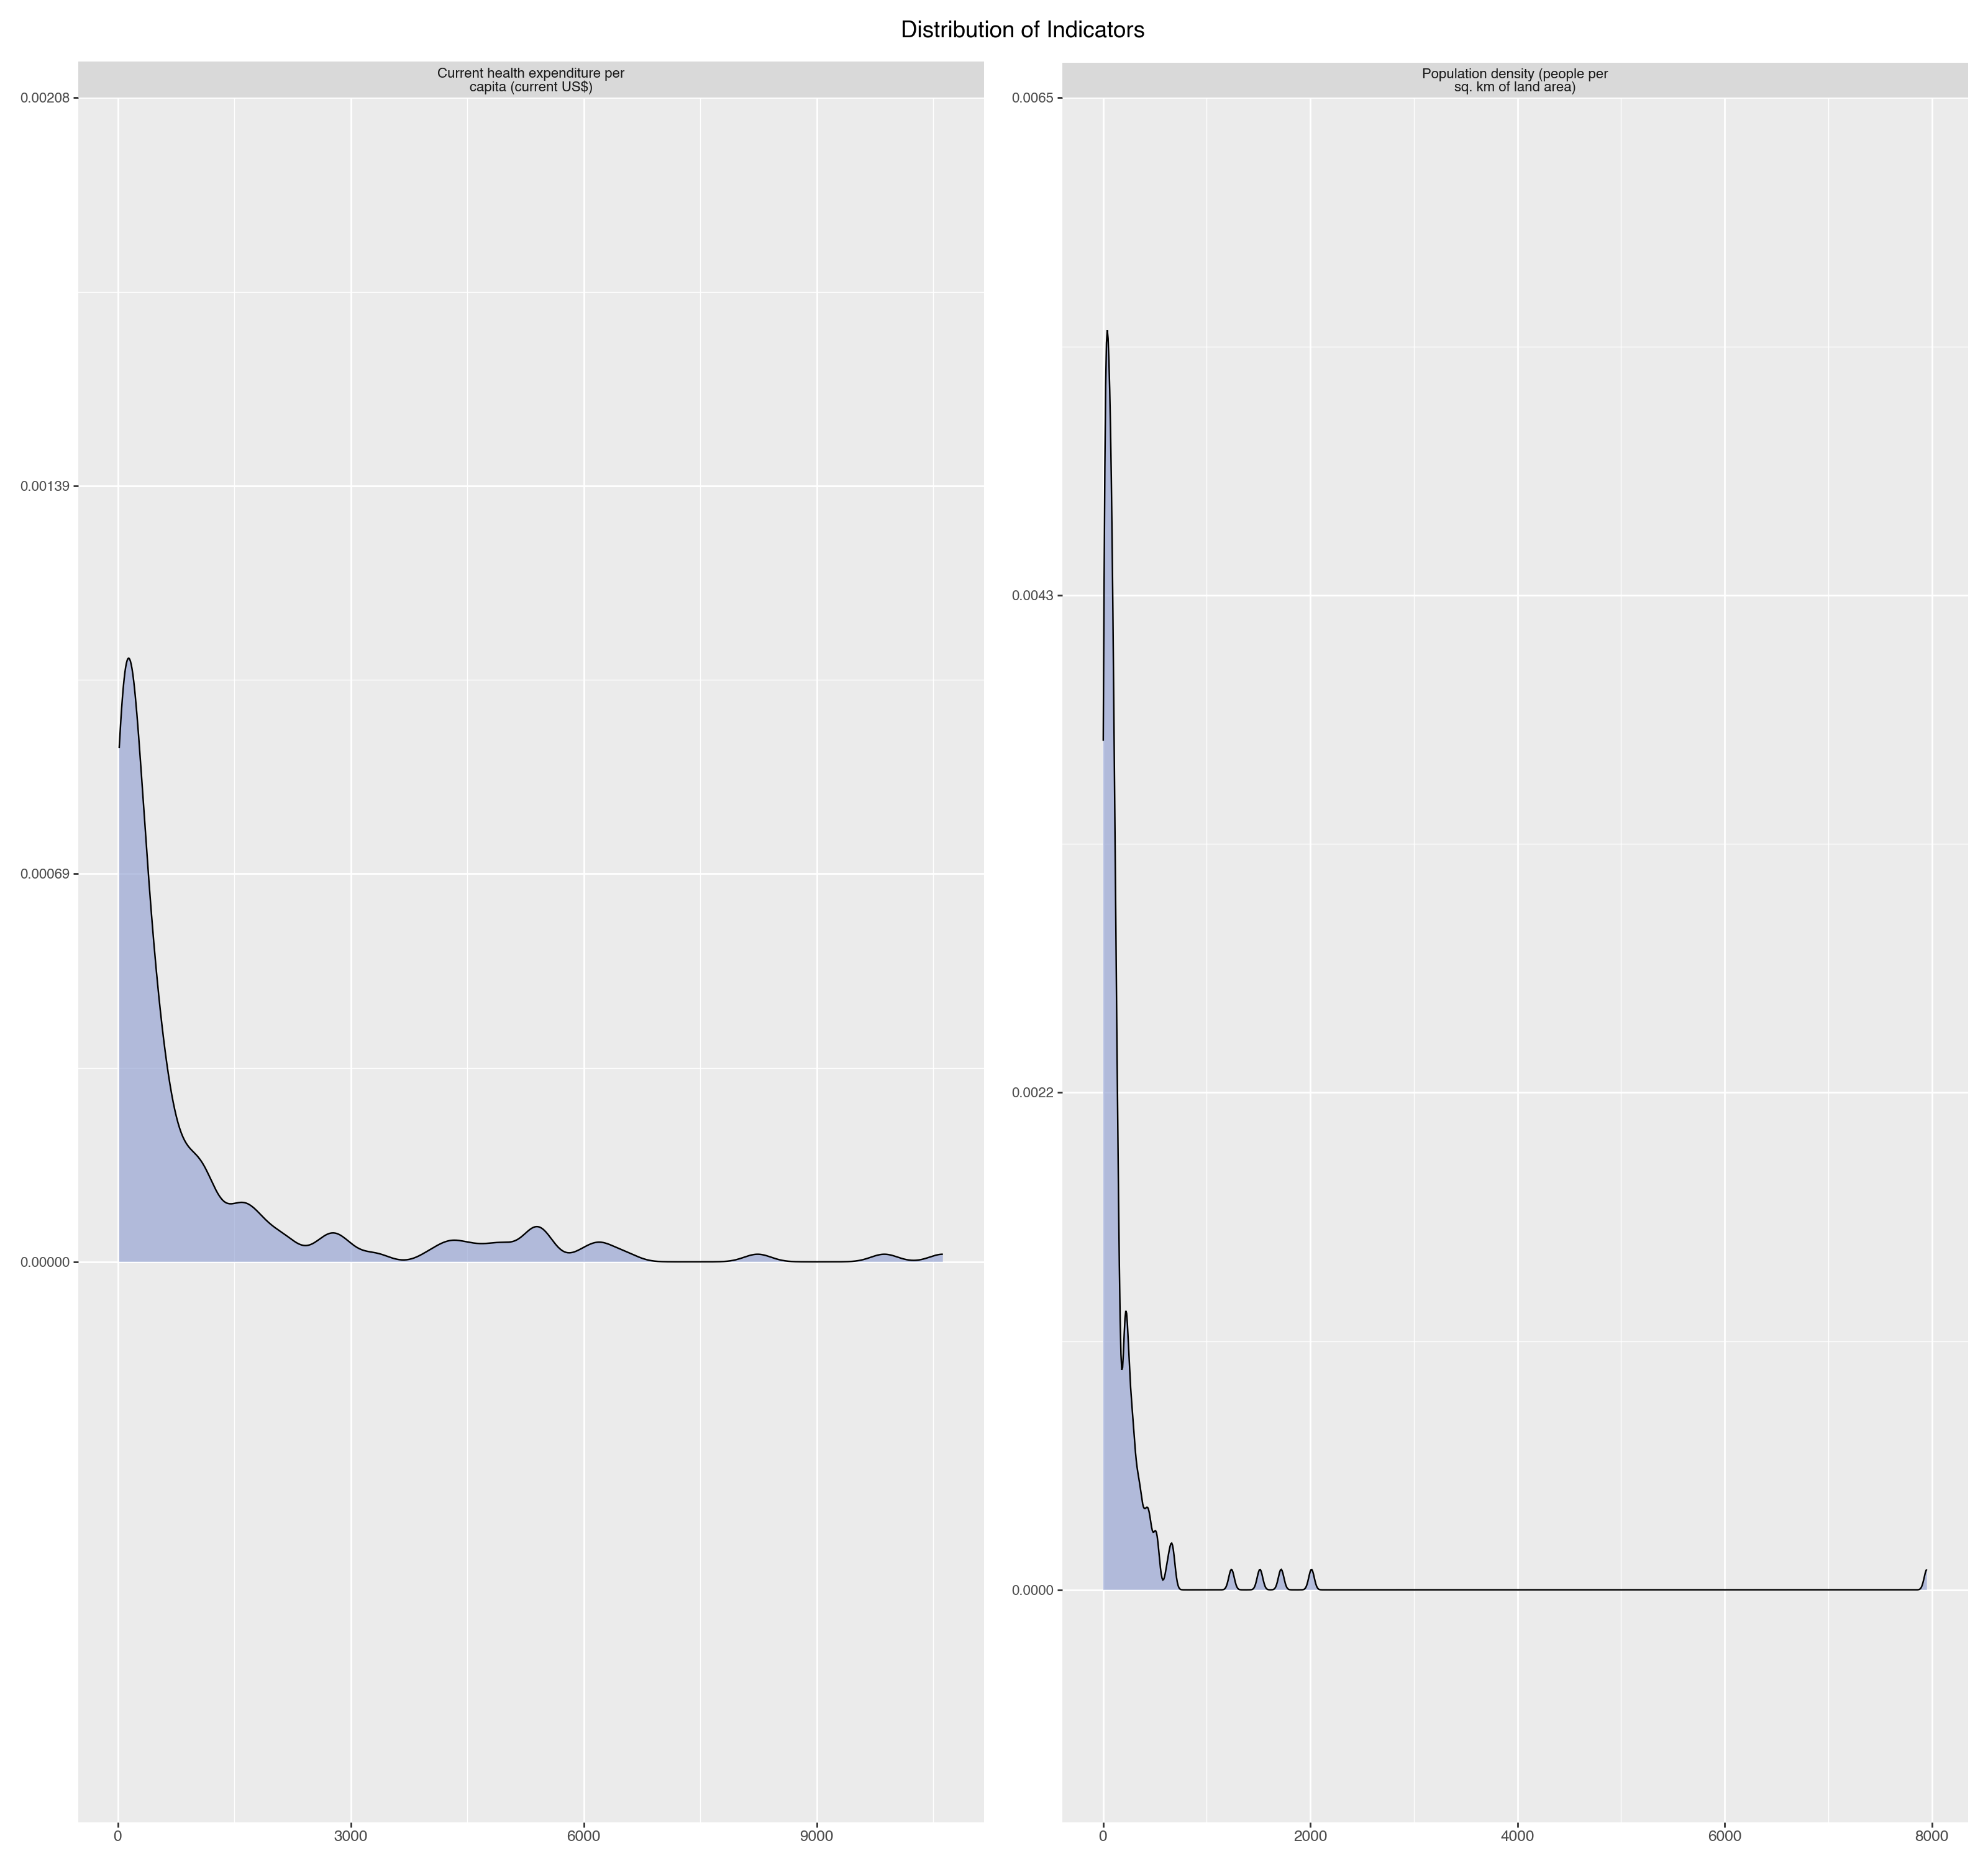

In [84]:

indicators_toplot_separately_group1=['Current health expenditure per capita (current US$)', 'Population density (people per sq. km of land area)']
indicators_toplot_separately_group2=['GDP per capita (current US$)','Land area (sq. km)']
indicators_toplot_separately_group3=['GDP (current US$)','Population, total']

# Plot
(
    ggplot(long_data[long_data["Indicator"].isin(indicators_toplot_separately_group1)], aes(x='Value'))
    + geom_density(fill='#98A6D4', alpha=0.7, adjust=0.7)  # Adjust the kernel density bandwidth for better smoothing
    + facet_wrap(
        '~Indicator',
        scales='free',  # Allow free scaling for both axes
        ncol=2,
        labeller=lambda x: "\n".join(wrap(x, 30))  # Wrap long indicator names
    )
    + labs(x='', y='', title="Distribution of Indicators")
    + theme(
        axis_text_y=element_text(size=8),       # Enable y-axis tick labels
        axis_ticks_y=element_text(),           # Enable y-axis ticks
        strip_text_x=element_text(size=8),     # Adjust facet label font size
        figure_size=(16, 15)                   # Adjust overall figure size
    )
    + scale_y_continuous(
        expand=(0.001, 0.001),  # Avoid excessive whitespace on the y-axis
        breaks=lambda limits: np.linspace(0, limits[1], 4).tolist()  # Set ticks dynamically
    )
)

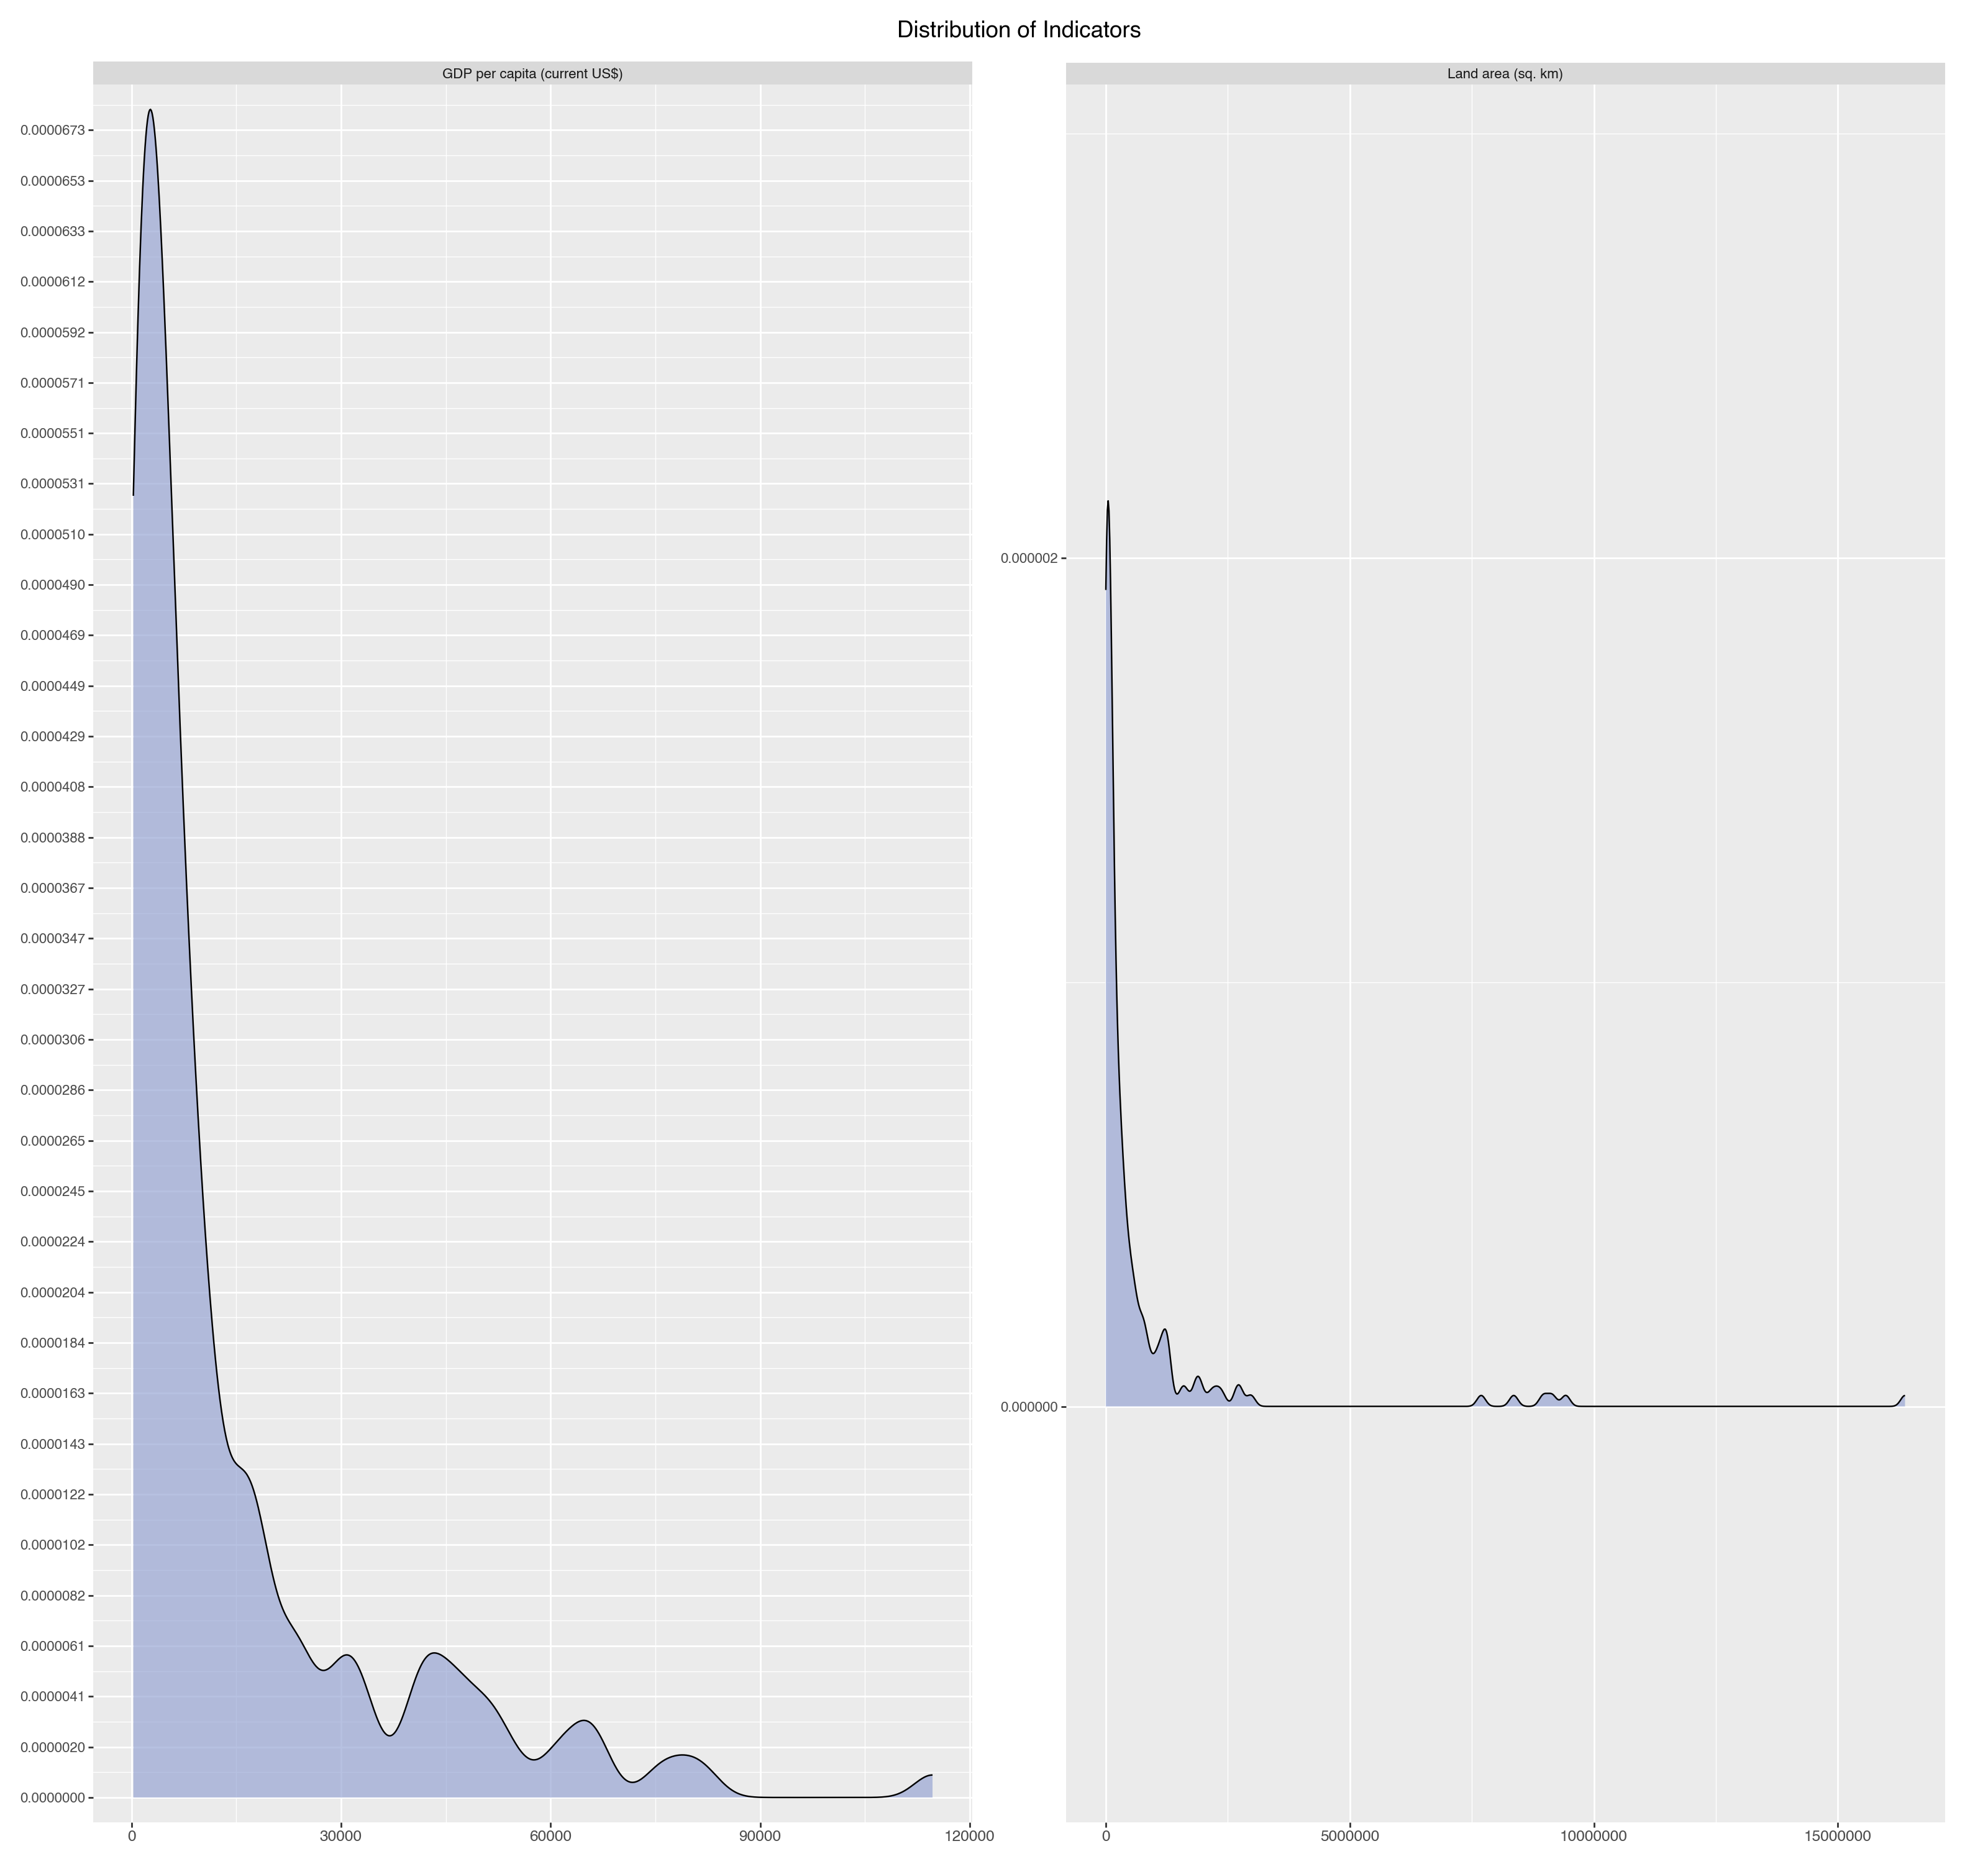

In [85]:
(
    ggplot(long_data[long_data["Indicator"].isin(indicators_toplot_separately_group2)], aes(x='Value'))
    + geom_density(fill='#98A6D4', alpha=0.7, adjust=0.7)  # Adjust the kernel density bandwidth for better smoothing
    + facet_wrap(
        '~Indicator',
        scales='free',  # Allow free scaling for both axes
        ncol=2,
        labeller=lambda x: "\n".join(wrap(x, 30))  # Wrap long indicator names
    )
    + labs(x='', y='', title="Distribution of Indicators")
    + theme(
        axis_text_y=element_text(size=8),       # Enable y-axis tick labels
        axis_ticks_y=element_text(),           # Enable y-axis ticks
        strip_text_x=element_text(size=8),     # Adjust facet label font size
        figure_size=(16, 15)                   # Adjust overall figure size
    )
    + scale_y_continuous(
        expand=(0.000001, 0.000001),  # Avoid excessive whitespace on the y-axis
        breaks=lambda limits: np.linspace(0, 0.0001, 50).tolist()  # Set ticks dynamically
    )
)


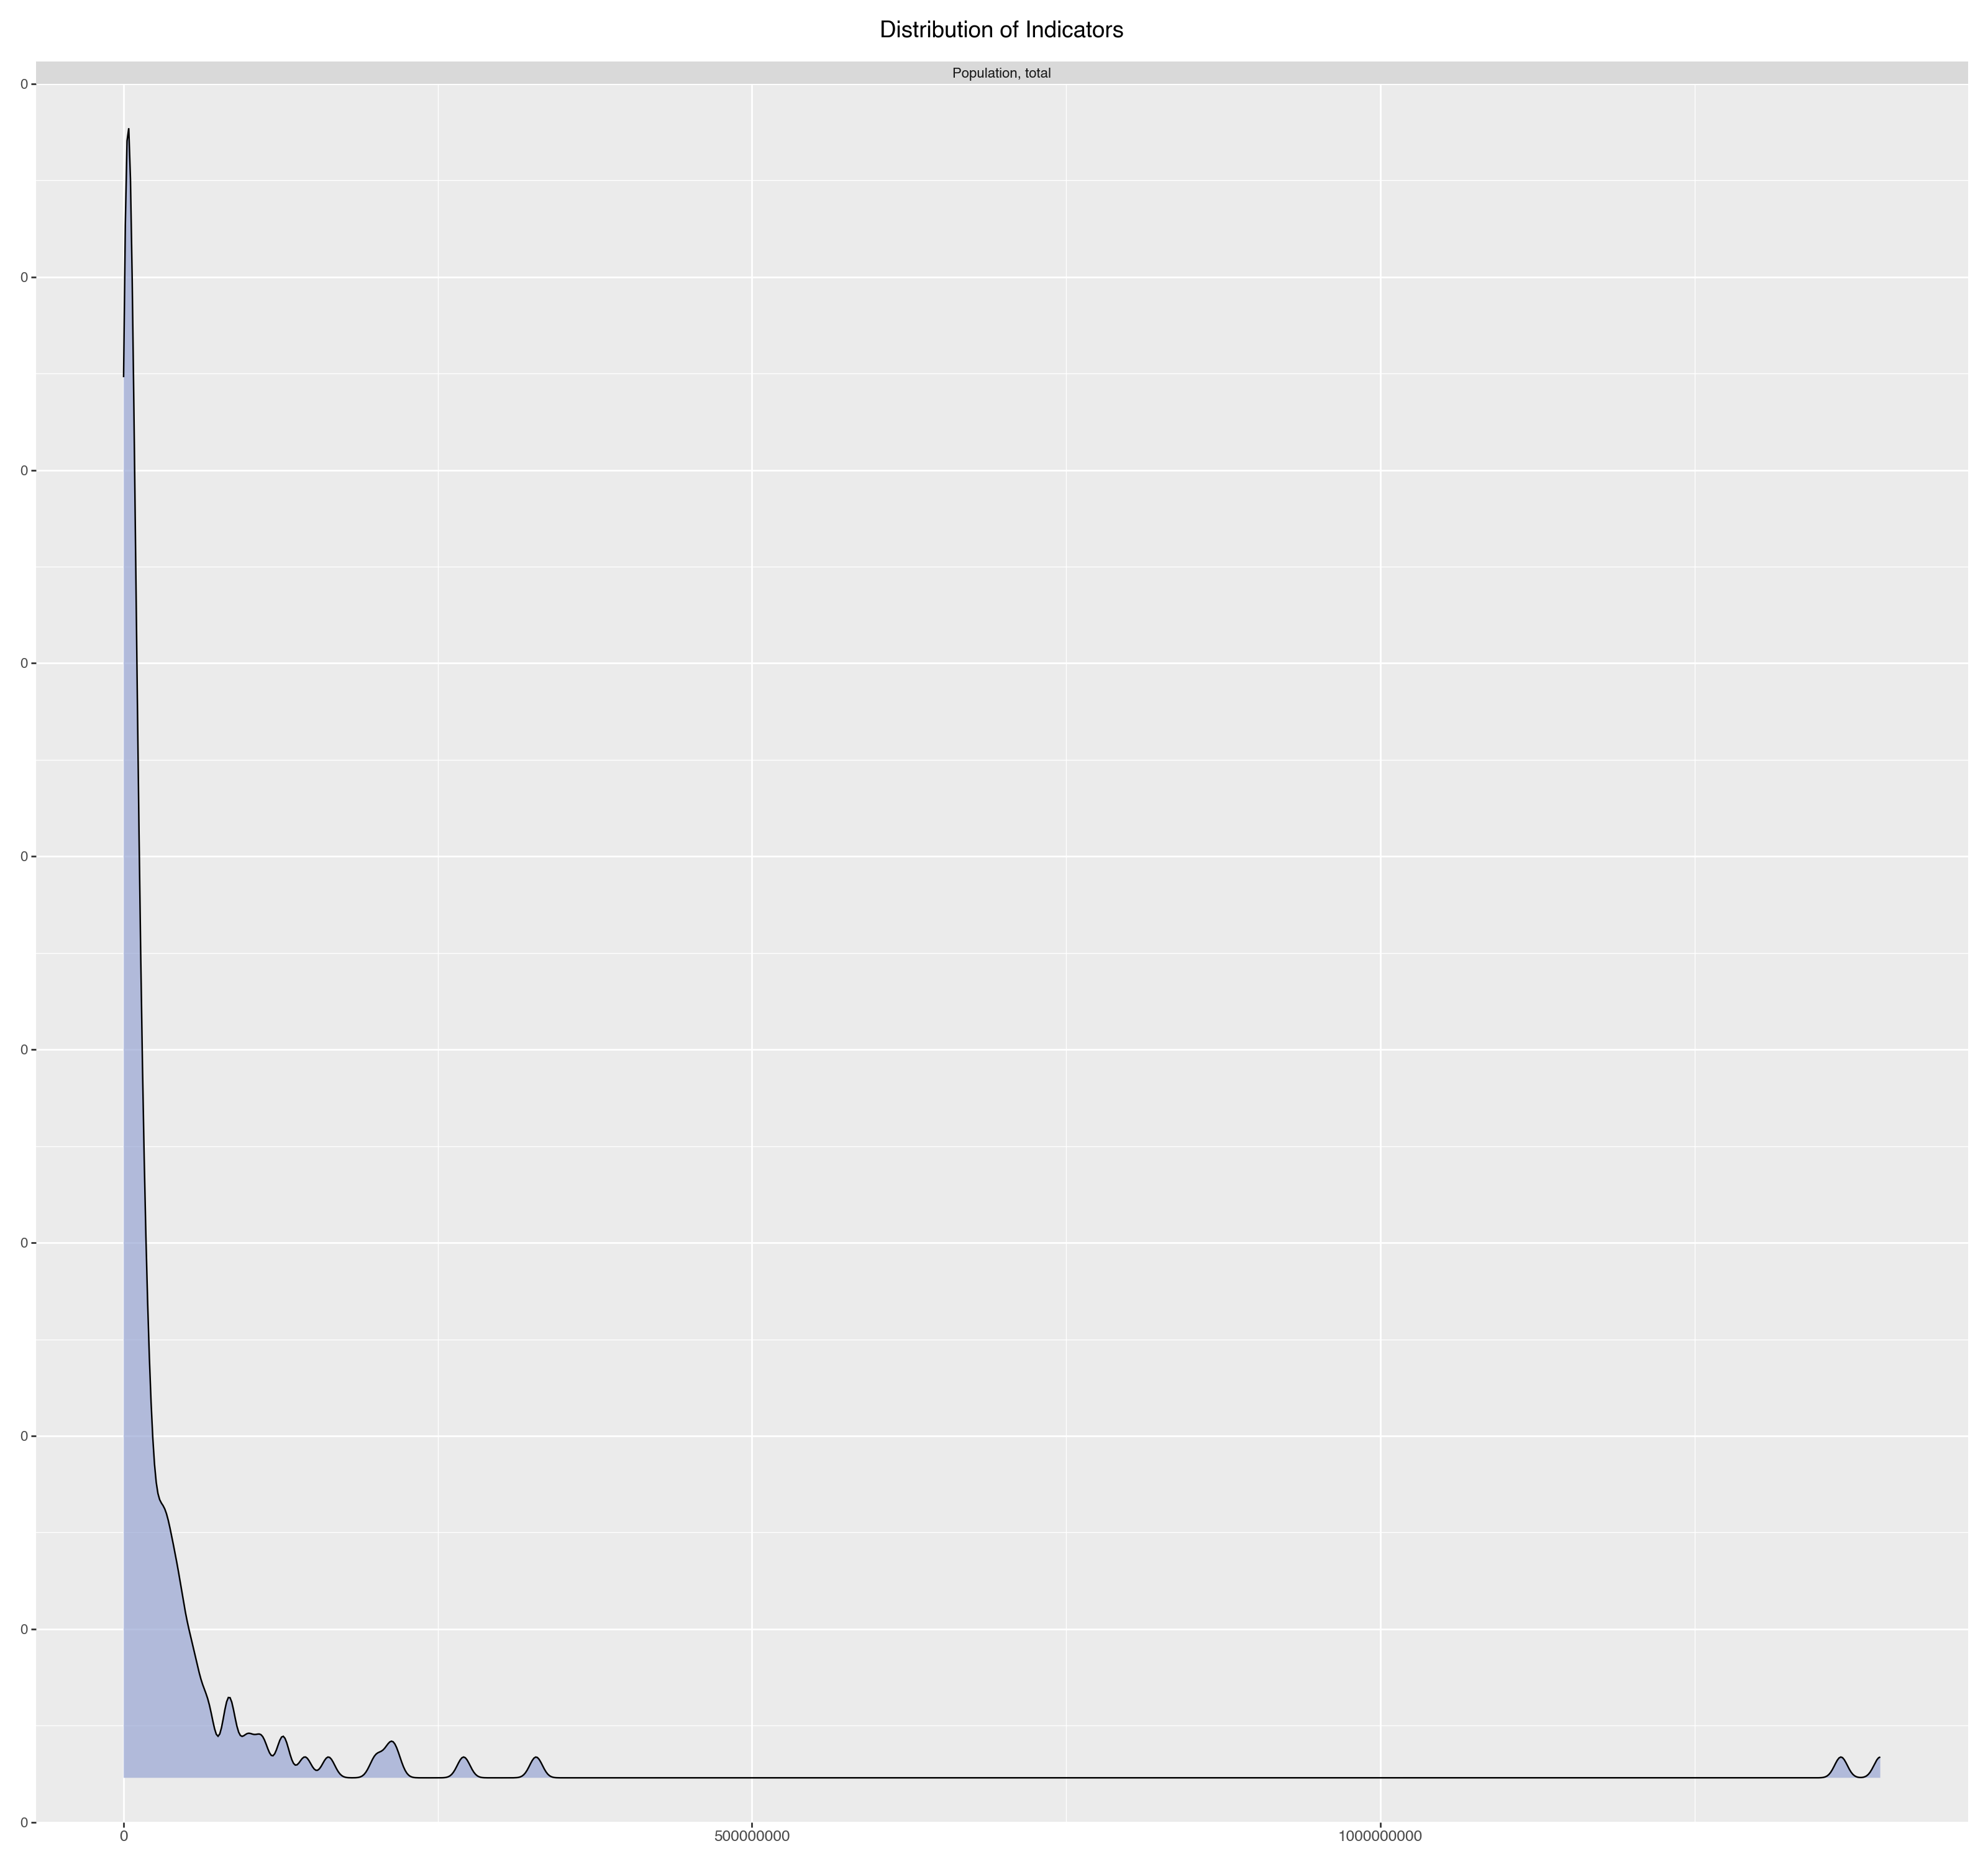

In [98]:
(
    ggplot(long_data[long_data["Indicator"].isin(["Population, total"])], aes(x='Value'))
    + geom_density(fill='#98A6D4', alpha=0.7, adjust=0.7)  # Adjust the kernel density bandwidth for better smoothing
    + facet_wrap(
        '~Indicator',
        scales='free',  # Allow free scaling for both axes
        ncol=2,
        labeller=lambda x: "\n".join(wrap(x, 30))  # Wrap long indicator names
    )
    + labs(x='', y='', title="Distribution of Indicators")
    + theme(
        axis_text_y=element_text(size=8),       # Enable y-axis tick labels
        axis_ticks_y=element_text(),           # Enable y-axis ticks
        strip_text_x=element_text(size=8),     # Adjust facet label font size
        figure_size=(16, 15)                   # Adjust overall figure size
    )
    + scale_y_continuous(
        expand=(0.000000001, 0.000000001),  # Avoid excessive whitespace on the y-axis
        breaks=lambda limits: np.linspace(limits[0], limits[1], 10).tolist()  # Set ticks dynamically
    )
)

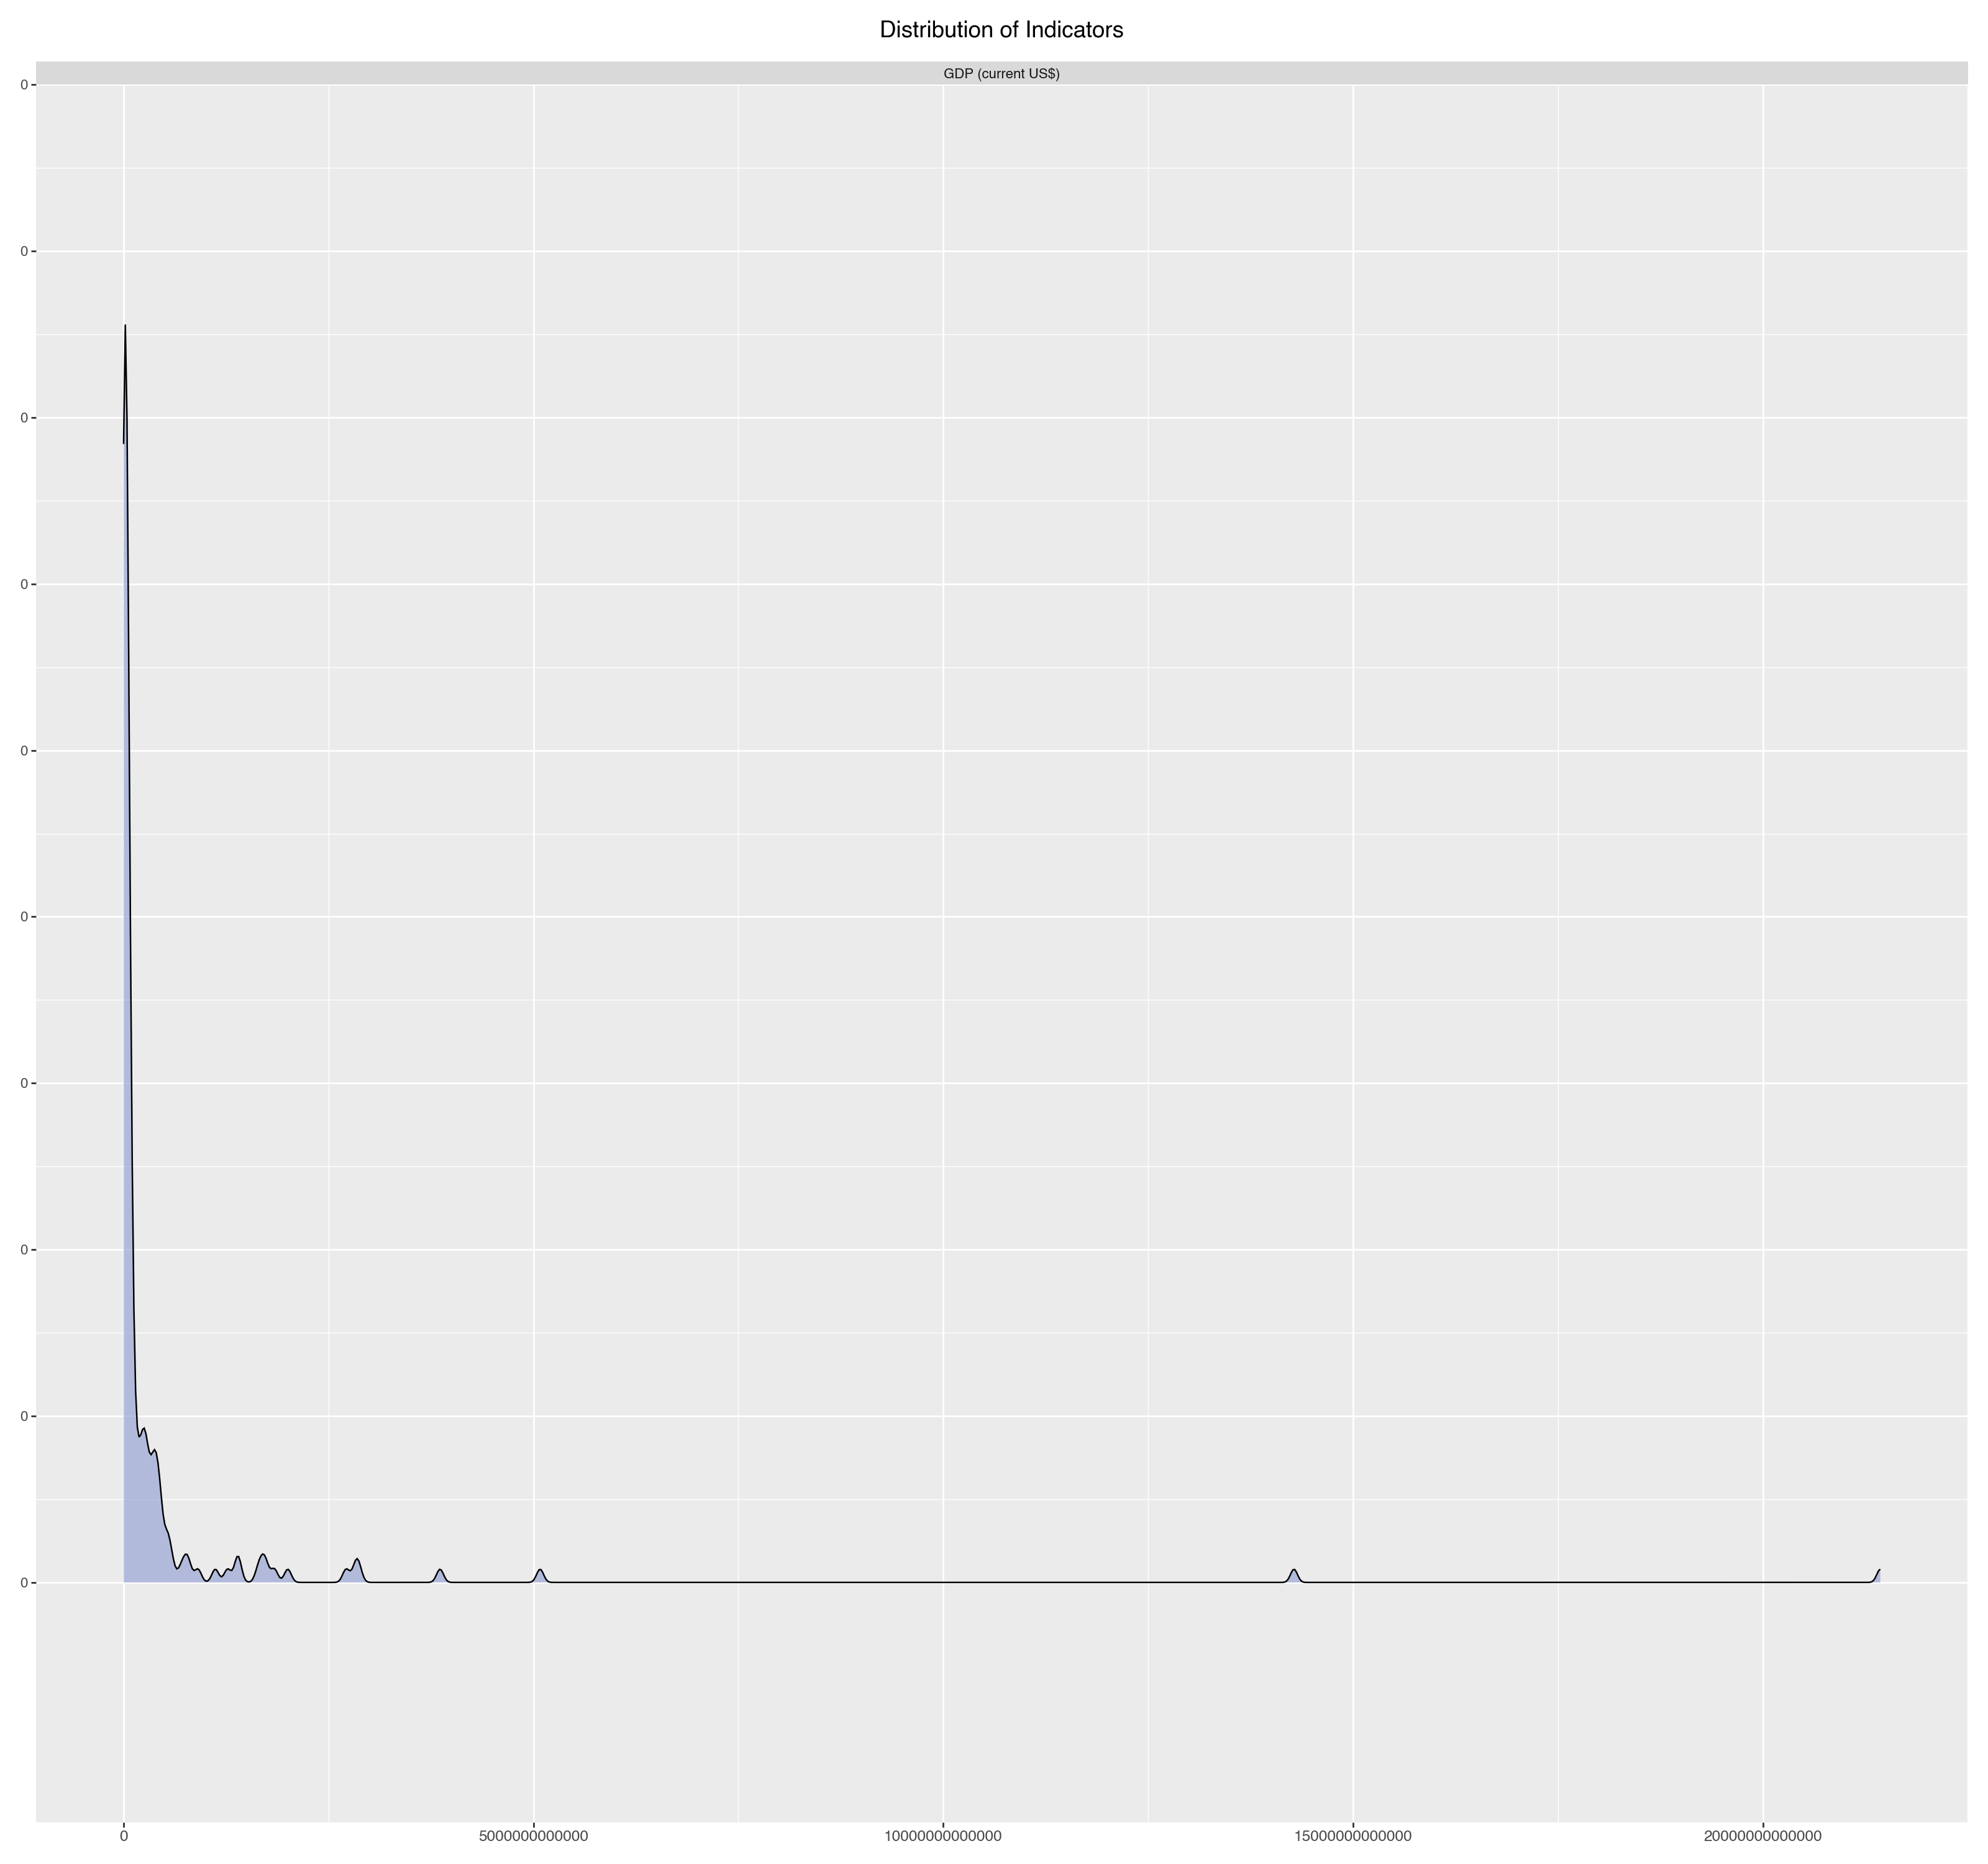

In [103]:
(
    ggplot(long_data[long_data["Indicator"].isin(["GDP (current US$)"])], aes(x='Value'))
    + geom_density(fill='#98A6D4', alpha=0.7, adjust=0.7)  # Adjust the kernel density bandwidth for better smoothing
    + facet_wrap(
        '~Indicator',
        scales='free',  # Allow free scaling for both axes
        ncol=2,
        labeller=lambda x: "\n".join(wrap(x, 30))  # Wrap long indicator names
    )
    + labs(x='', y='', title="Distribution of Indicators")
    + theme(
        axis_text_y=element_text(size=8),       # Enable y-axis tick labels
        axis_ticks_y=element_text(),           # Enable y-axis ticks
        strip_text_x=element_text(size=8),     # Adjust facet label font size
        figure_size=(16, 15)                   # Adjust overall figure size
    )
    + scale_y_continuous(
        expand=(0.000000000001, 0.000000000001),  # Avoid excessive whitespace on the y-axis
        breaks=lambda limits: np.linspace(0, limits[1], 10).tolist()  # Set ticks dynamically
    )
)

In [106]:
development_indicators[["country_name","Ease of doing business score (0 = lowest performance to 100 = best performance)","WGI - ControlofCorruption"]].head()

country_name  \
0           Afghanistan   
1                Angola   
2               Albania   
3  United Arab Emirates   
4             Argentina   

   Ease of doing business score (0 = lowest performance to 100 = best performance)  \
0                                           44.06497                                 
1                                           41.28838                                 
2                                           67.74847                                 
3                                           80.91489                                 
4                                           58.96151                                 

   WGI - ControlofCorruption  
0                  -1.401076  
1                  -1.054683  
2                  -0.528758  
3                   1.106342  
4                  -0.071071

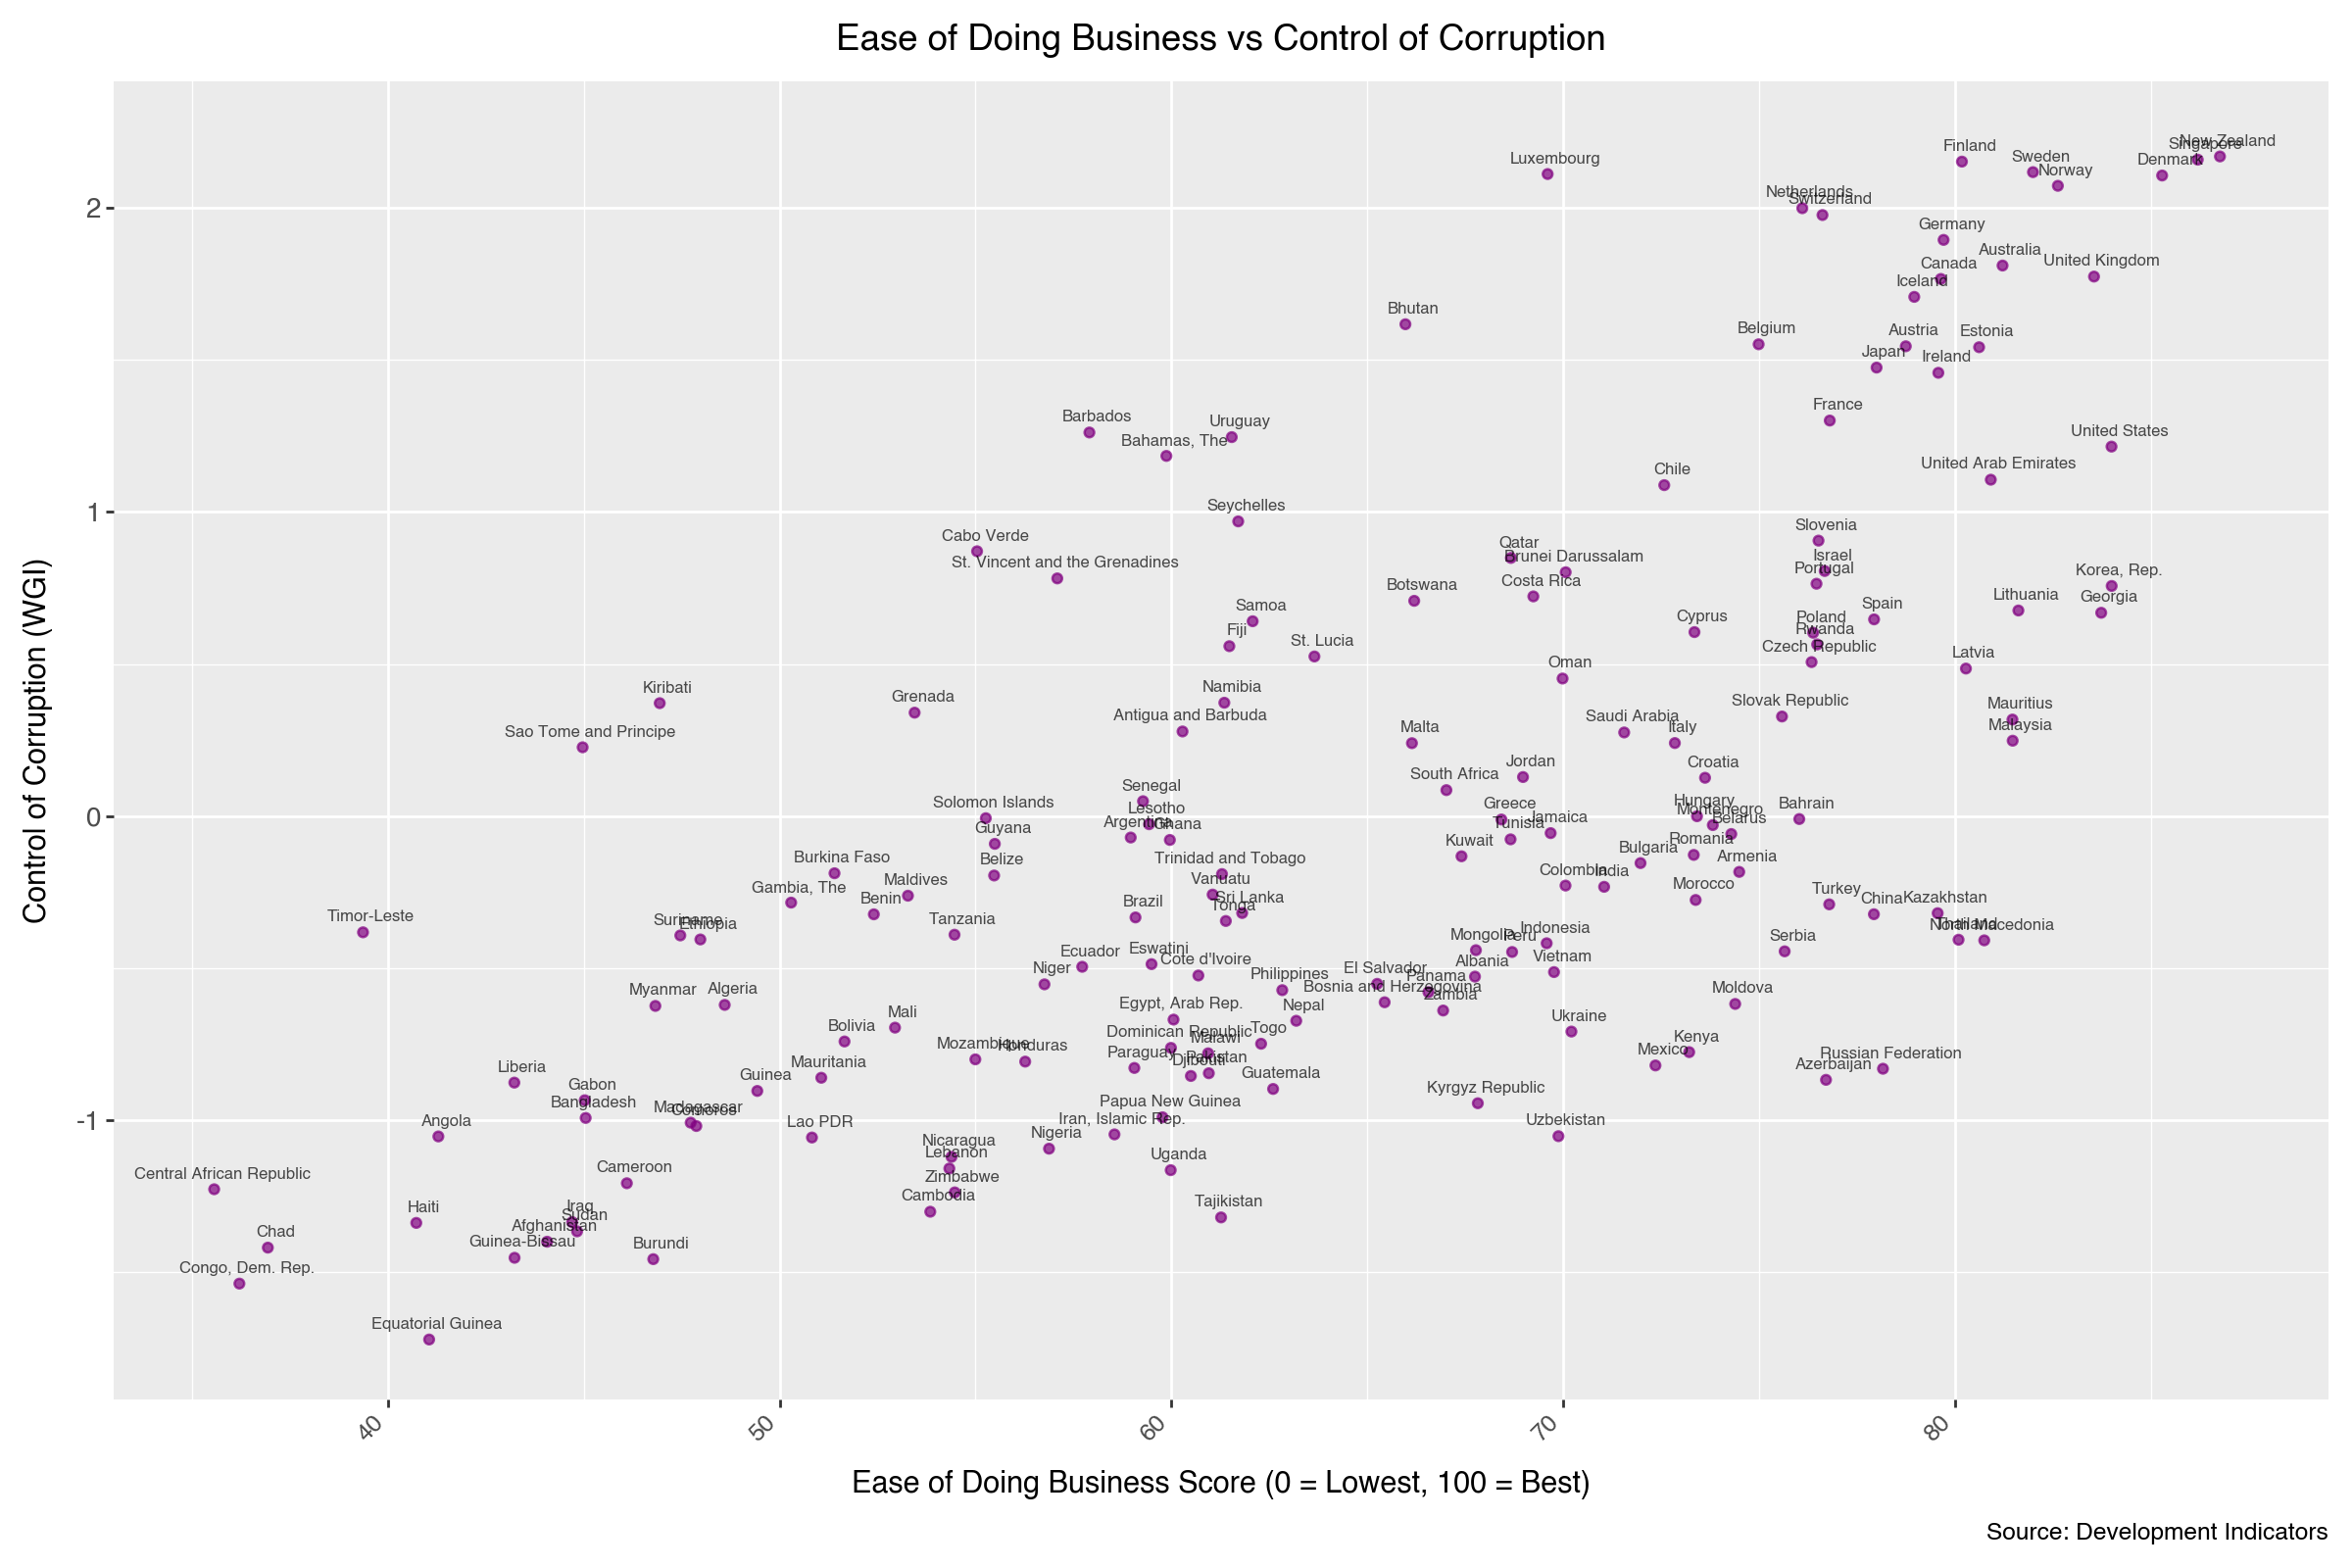

In [ ]:


# Plot Ease of doing business vs WGI - Control of Corruption with rotated labels and crosses
(
    ggplot(development_indicators, aes(x='Ease of doing business score (0 = lowest performance to 100 = best performance)', 
                                      y='WGI - ControlofCorruption', label='country_name'))
    + geom_point(color='purple', alpha=0.7)  # Scatter plot with crosses (shape 'x')
    + geom_text(aes(label='country_name'), size=6, alpha=0.7, nudge_y=0.05, nudge_x=0.2)  # Rotate the country labels
    + labs(title="Ease of Doing Business vs Control of Corruption",
           x="Ease of Doing Business Score (0 = Lowest, 100 = Best)",
           y="Control of Corruption (WGI)",
           caption="Source: Development Indicators")
    + theme(
        axis_text_x=element_text(rotation=45, ha='right'),  # Rotate x-axis labels for readability
        axis_text_y=element_text(size=10),
        strip_text_x=element_text(size=10),
        figure_size=(12, 8)
    )
)




In [6]:
X=development_indicators[["country_name","Ease of doing business score (0 = lowest performance to 100 = best performance)","WGI - ControlofCorruption"]]

In [137]:
X.iloc[:,[1, 2]]

Ease of doing business score (0 = lowest performance to 100 = best performance)  \
0                                             44.06497                                 
1                                             41.28838                                 
2                                             67.74847                                 
3                                             80.91489                                 
4                                             58.96151                                 
..                                                 ...                                 
165                                           61.05191                                 
166                                           62.07404                                 
167                                           67.01897                                 
168                                           66.93648                                 
169                                           54.46935                                 

     WGI - ControlofCorruption  
0                    -1.401076  
1                    -1.054683  
2                    -0.528758  
3                     1.106342  
4                    -0.071071  
..                         ...  
165                  -0.258875  
166                   0.640636  
167                   0.084924  
168                  -0.640345  
169                  -1.238796  

[170 rows x 2 columns]

We determine the number of parameters for k-means with the "elbow method".

- In this method, we vary the number of clusters `k`, apply k-means to the data and measure what we call the within-cluster-sum-of-squares (WCSS) i.e the sum of the squared distance between each point in a cluster and the centroid of the cluster it belongs to. 
- We then plot the WCSS against `k`: the optimal value of clusters (i.e the number of clusters we need to choose for k-means) corresponds to the value of `k` starting from which the decrease rate of the WCSS curve inflects and the graph starts to look like a straight line.

Note that we initialize the K-means runs with the K-means++ initialization (see details in see details in Arthur, D.; Vassilvitskii, S. (2007). "[k-means++: the advantages of careful seeding](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf)". Proceedings of the eighteenth annual ACM-SIAM symposium on Discrete algorithms. Society for Industrial and Applied Mathematics Philadelphia, PA, USA. pp. 1027–1035). This means that we don't go with the default **random initialization** usually used by default with K-Means but proceed with a "more clever" way of initializing which consists in choosing centroids such that they are as far as possible from each other.

K-means initialization is important! Two random initializations can result in totally different clustering outcomes

E.g:

Random initialization 1:

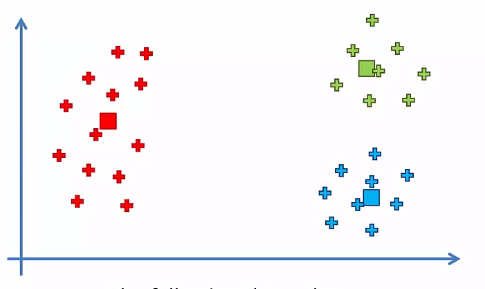

Random initialization 2:

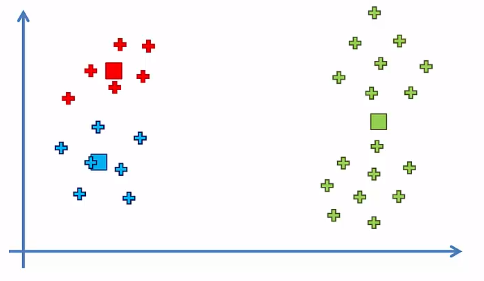

In [138]:
# Using the elbow method to find the optimal number of clusters
# https://iq.opengenus.org/k-means-vs-k-means-p/
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42,n_init='auto')
    kmeans.fit(X.iloc[:,[1,2]])
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

We plot the "elbow plot"

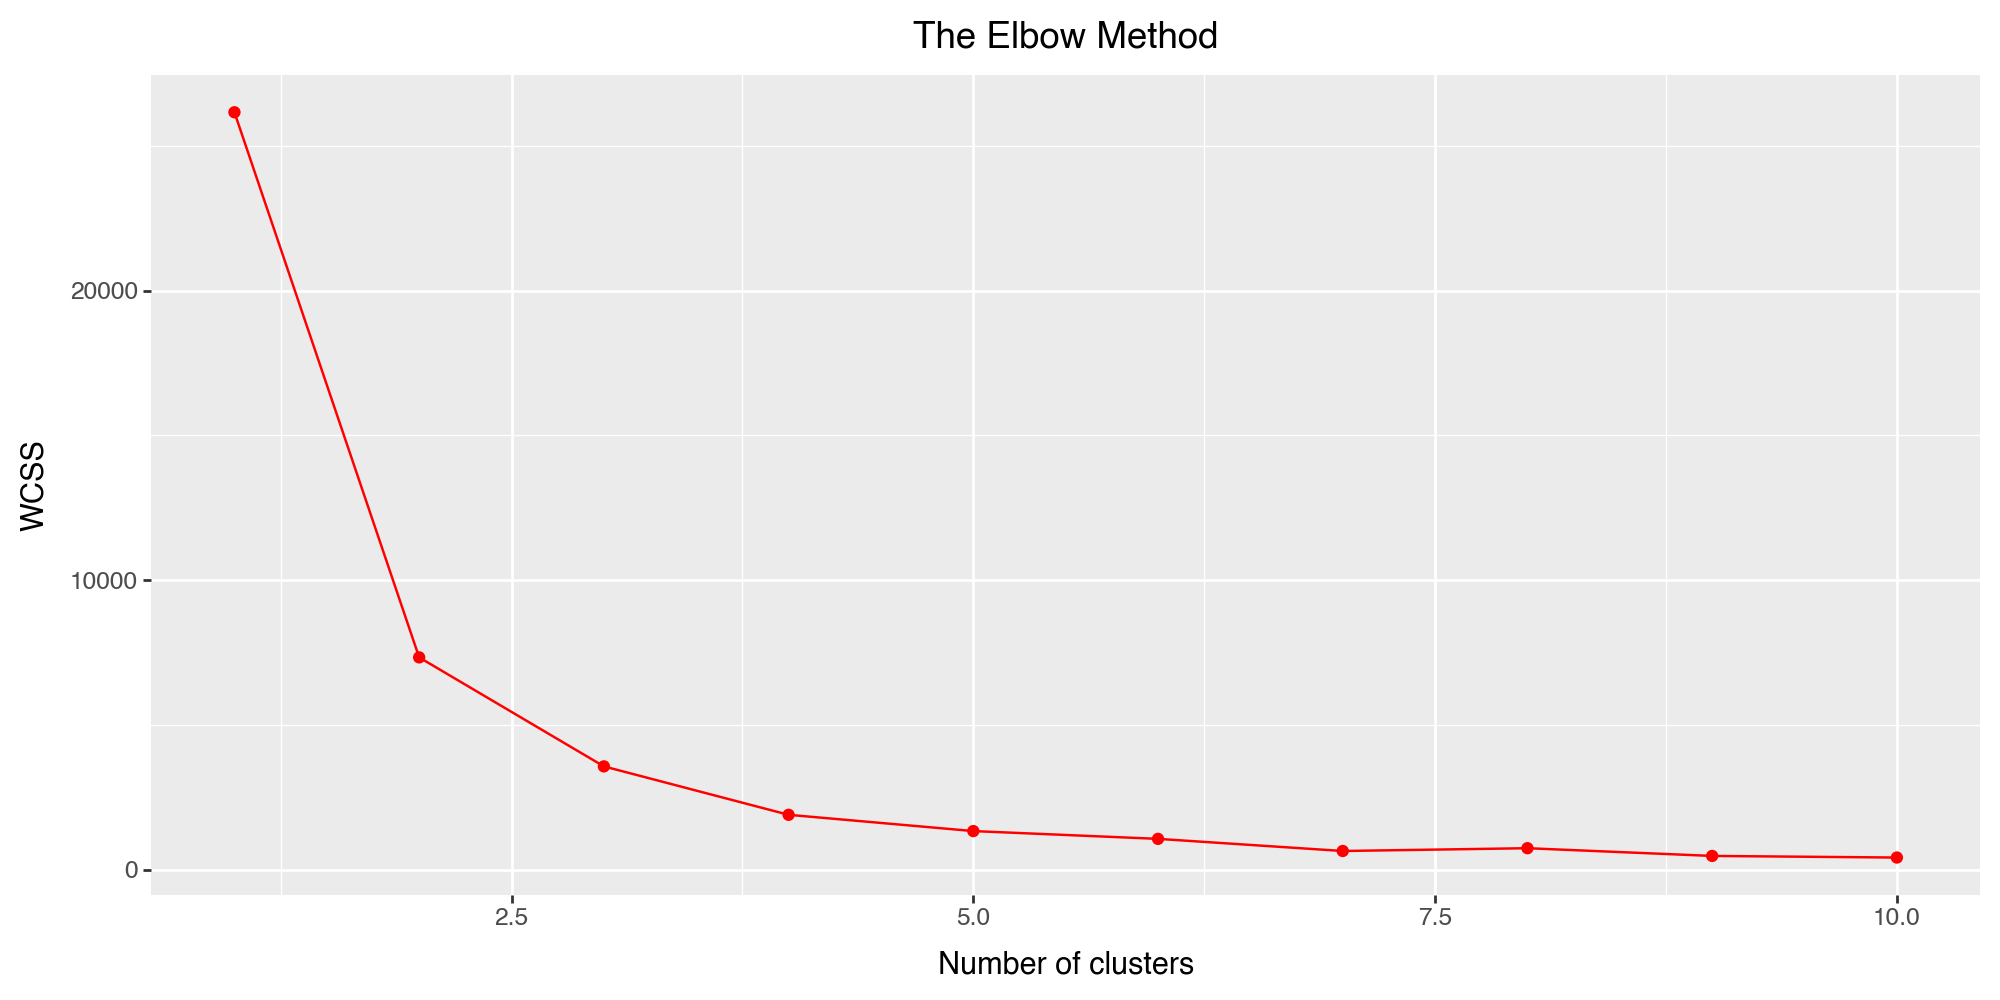

In [139]:
data = pd.DataFrame({
    'Clusters': range(1, 11),
    'WCSS': wcss  # Replace 'wcss' with your actual WCSS values
})

# Create the plot
(
    ggplot(data, aes(x='Clusters', y='WCSS'))  # x-axis is 'Clusters', y-axis is 'WCSS'
    + geom_line(color='red')  # Line plot with red color
    + geom_point(color='red')  # Add points at each cluster number
    + labs(title='The Elbow Method',
           x='Number of clusters',
           y='WCSS')  # Set labels for title, x, and y axes
    + theme(figure_size=(10, 5))  # Set figure size to match the original
)

The plot above shows that the WCSS curve inflects and flattens for a `k` value of 3: so the optimal number of clusters is 3. This is the parameter we'll pass to the k-means algorithm.

In [157]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42,n_init='auto')
y_kmeans = kmeans.fit_predict(X.iloc[:,[1,2]])

Finally, we plot the results of our clustering.

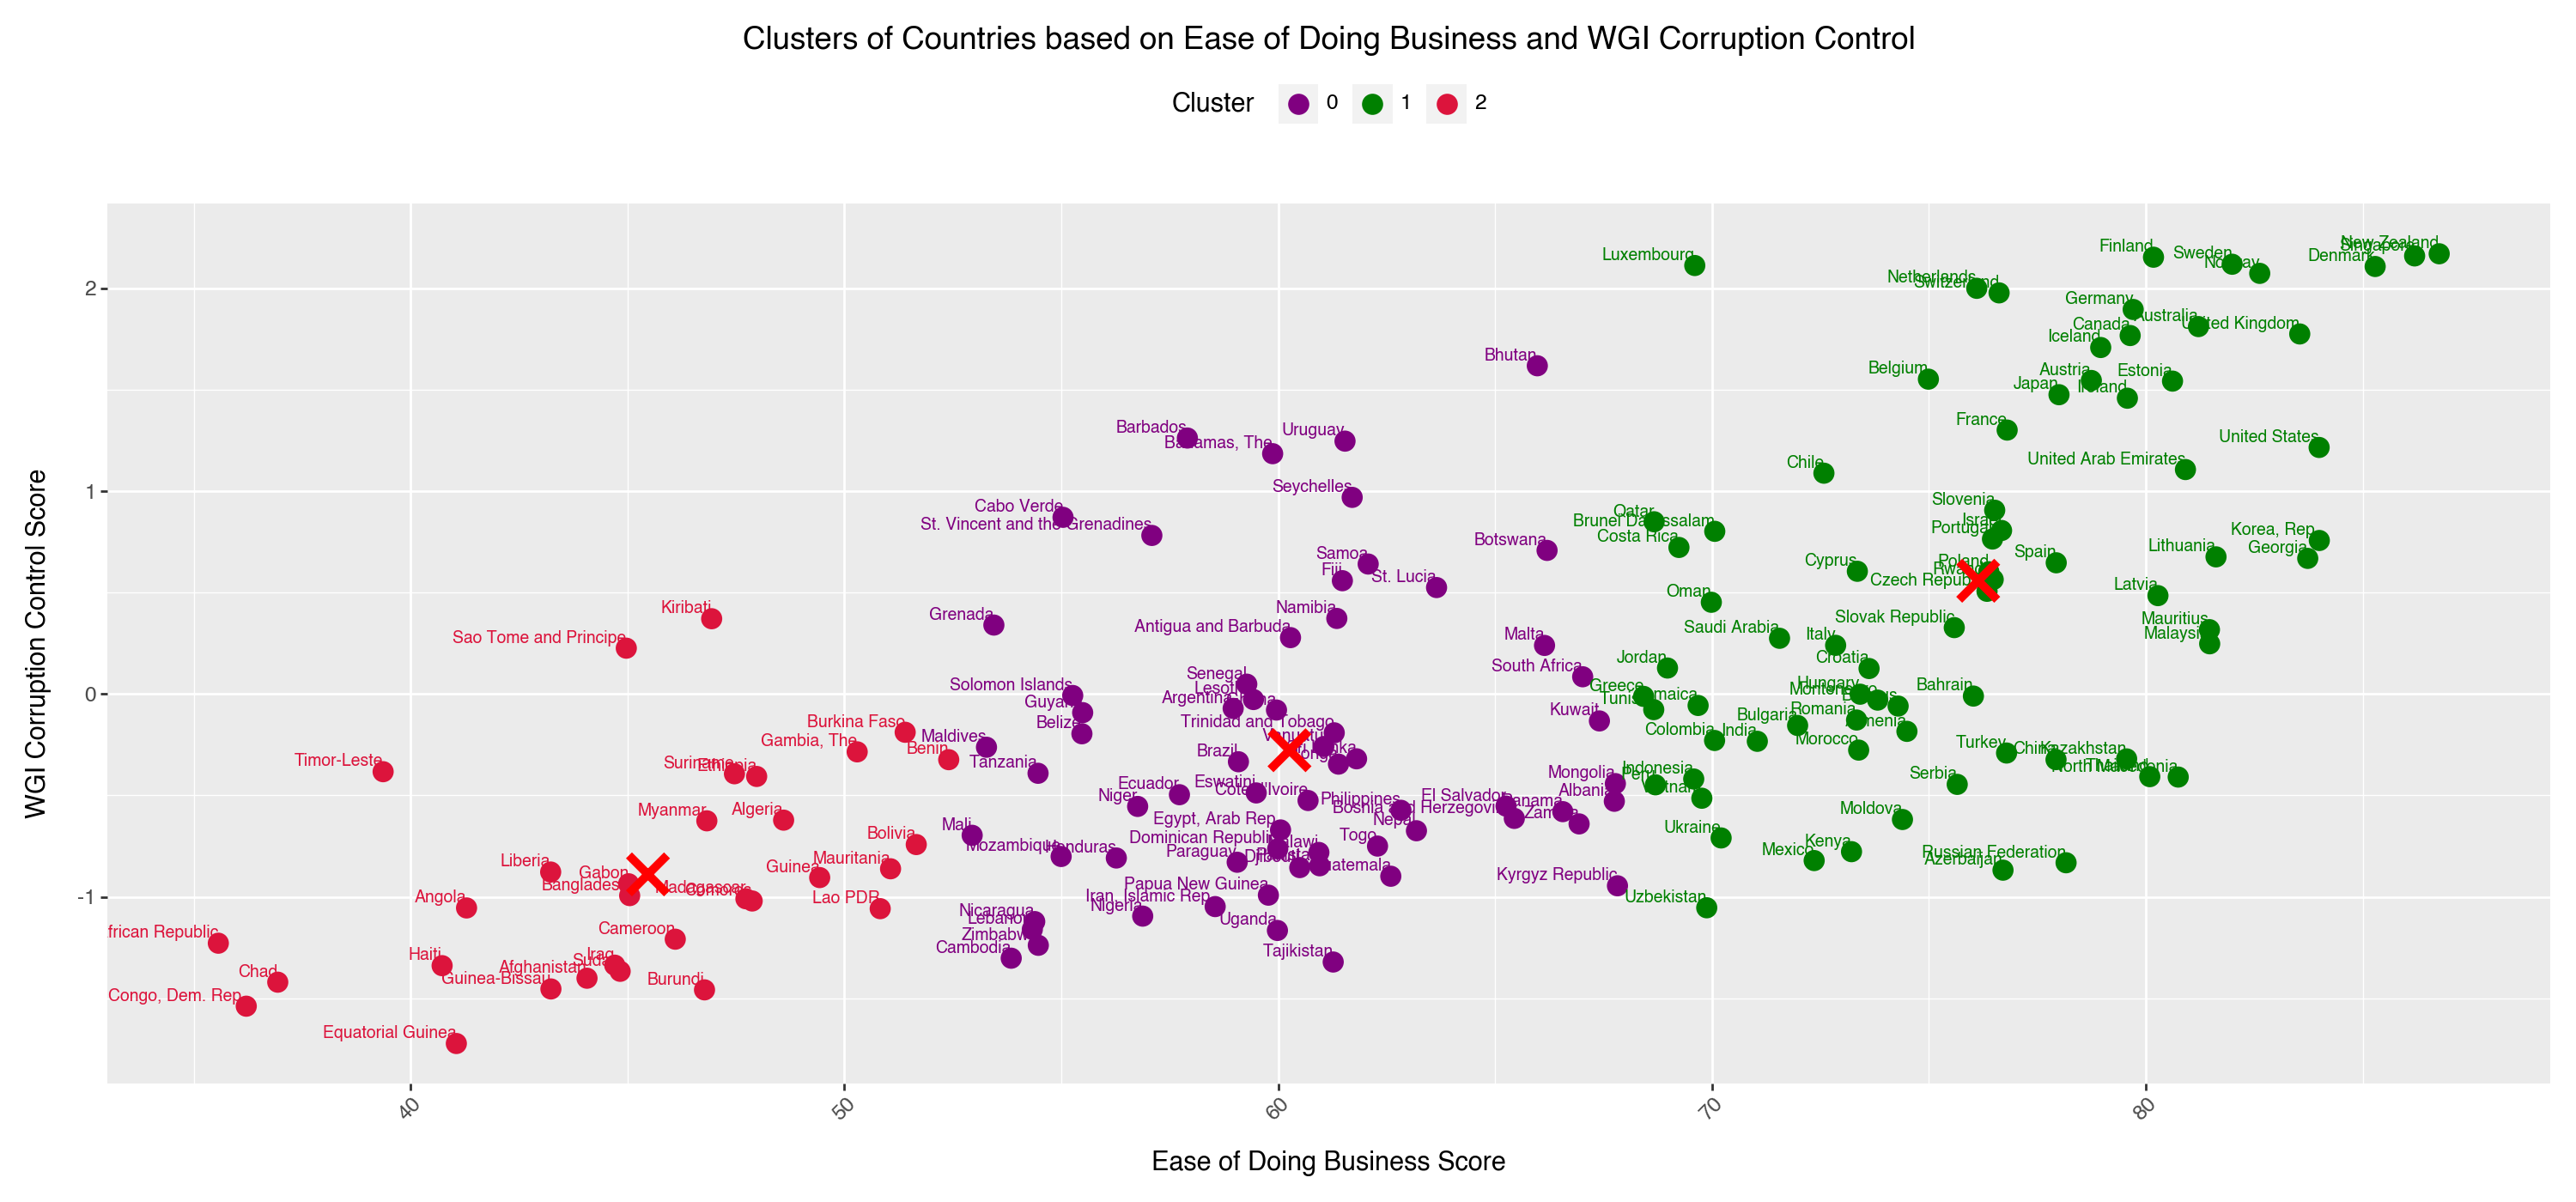

In [ ]:
# Plot using plotnine

# Assuming data is already available
data = pd.DataFrame({
    'country_name': X.iloc[:,0],  # Assuming country names are stored in the first column of 'X'
    'ease_of_doing_business': X.iloc[:,1],  # Assuming the Ease of Doing Business is in the second column
    'wgi_controlling_corruption': X.iloc[:,2],  # Assuming the WGI Corruption Control is in the third column
    'cluster': y_kmeans  # Cluster labels
})

# Prepare centroids dataframe with proper column names matching the data
centroids = pd.DataFrame({
    'ease_of_doing_business': kmeans.cluster_centers_[:, 0],  # X-coordinate of centroids
    'wgi_controlling_corruption': kmeans.cluster_centers_[:, 1],  # Y-coordinate of centroids
    'cluster': range(3)  # Cluster number, should match the number of clusters
})

# Plot using plotnine
(
    ggplot(data, aes(x='ease_of_doing_business', y='wgi_controlling_corruption', color='factor(cluster)'))  # Color by cluster
    + geom_point(aes(color='factor(cluster)'), size=4)  # Scatter plot for data points
    + geom_text(aes(label='country_name'), size=7, ha='right', nudge_y=0.05)  # Labels each point by country_name
    + geom_point(data=centroids, mapping=aes(x=centroids['ease_of_doing_business'], y=centroids['wgi_controlling_corruption']), 
                 color='red', size=7, shape='x', stroke=2)  # Plot centroids with 'X' shape and stroke
    + scale_color_manual(values=['purple', 'green', 'crimson'])  # Cluster colors
    + labs(title='Clusters of Countries based on Ease of Doing Business and WGI Corruption Control',
           x='Ease of Doing Business Score',
           y='WGI Corruption Control Score',
           color='Cluster')
    + theme(figure_size=(15, 7), legend_position='top', axis_text_x=element_text(rotation=45))  # Rotate x-axis labels for readability
)



# Clustering differently: Density-based clustering with DBSCAN

## About DBSCAN
 

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based unsupervised learning algorithm. It computes nearest neighbor graphs to find arbitrary-shaped clusters and outliers. DBSCAN can generate clusters of arbitrary shape and also singles out outliers: by constrast, K-means clustering generates spherical-shaped clusters and fits all the data points within the space (including outliers) into a cluster. 

Unlike K-means, DBSCAN does not require `K`, the number of clusters, as an input parameter. Instead, it requires two parameters: `eps` and `minPts`.

- eps: it is the radius of specific neighborhoods. If the distance between two points is less than or equal to `eps`, the two points will be considered to belong to the same neighbourhood
- minPts: minimum number of data points in a given neighborhood to form the clusters. 
  
DBSCAN uses these two parameters to define core points, border points, or outliers.

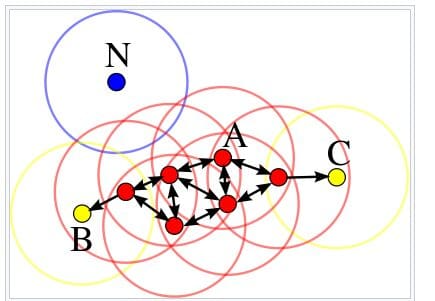

*How does the DBSCAN clustering algorithm work?*
 

It starts by randomly selecting any point `p`. 
It is also called a core point if there are more data points than `minPts` in the neighborhood of radius `eps`. 
It will use `eps` and `minPts` to identify all density reachable points (i.e all the points reachable via a set of core points).
It will create a cluster using `eps` and `minPts` if `p` is a core point. 
It will move to the next data point if `p` is a border point. A data point is called a border point if it has fewer points than `minPts` in the neighborhood. 
The algorithm will continue until all points are visited.
A point which is neither a core or border point is an outlier...

If this explanation confuses you, you can have a look at [this Youtube video](https://www.youtube.com/watch?app=desktop&v=RDZUdRSDOok).

Or you can have a look at [this page](https://www.reneshbedre.com/blog/dbscan-python.html) if you want even more details and a look at another demo! Here's another [page](https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556) for the technical details of DBSCAN. You can also check the original DBSCAN paper at Martin Ester, Hans-Peter Kriegel, Jörg Sander, and Xiaowei Xu. 1996. [*A density-based algorithm for discovering clusters in large spatial databases with noise*](https://dl.acm.org/doi/10.5555/3001460.3001507). In Proceedings of the Second International Conference on Knowledge Discovery and Data Mining (KDD'96). AAAI Press, 226–231..

We fit `X` (the same dataset as earlier) on the DBSCAN algorithm with `eps` 1.19 and `min_sample` 4. After that, we create a `DBSCAN_dataset` from `X` and create a ‘Cluster’ column using `clustering.labels_` (i.e the labels created by DBSCAN). 

In [20]:
clustering = DBSCAN(eps=1.19, min_samples=4).fit(X.iloc[:,[1,2]])
DBSCAN_dataset = X.copy()
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 

To visualize the distribution of clusters, we use value_counts() and convert it into a dataframe. 

As you can see, we have 5 clusters and 1 outlier "class" (outliers are given the -1 label by DBSCAN). The `0` cluster has the largest size with 59 rows. 

In [21]:
DBSCAN_dataset.Cluster.value_counts().to_frame()

count
Cluster       
 1          59
 3          55
 0          18
 2          18
-1          15
 4           5

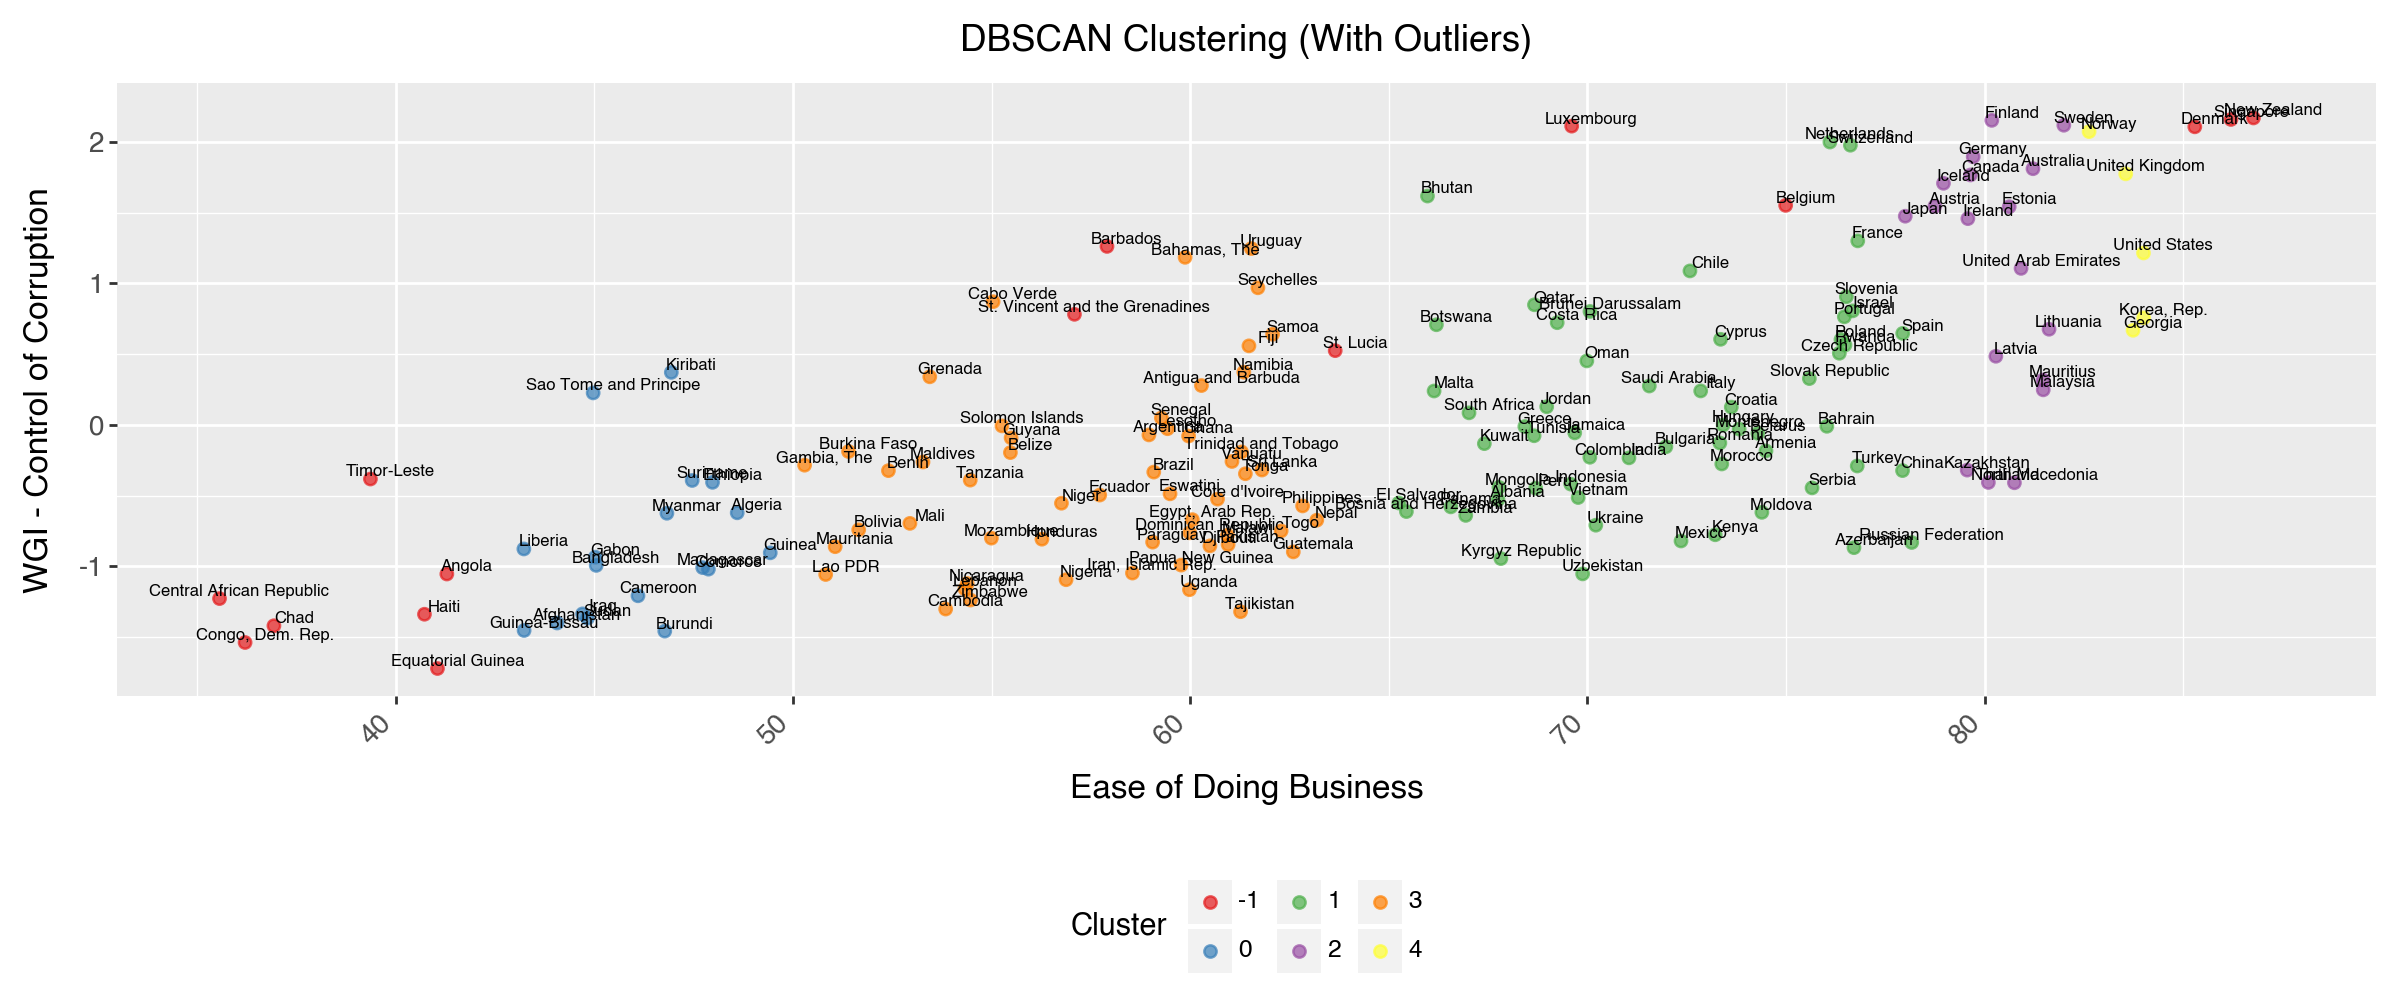

In [39]:
# Create DataFrame
data = pd.DataFrame({
    'country_name': DBSCAN_dataset.iloc[:, 0],  # Country names
    'ease_of_doing_business': DBSCAN_dataset.iloc[:, 1],  # Ease of Doing Business
    'wgi_controlling_corruption': DBSCAN_dataset.iloc[:, 2],  # WGI Corruption Control
    'cluster': DBSCAN_dataset.iloc[:, 3].astype('category')  # Cluster labels as categorical variable
})

# Add label for outliers
data['label'] = data.apply(lambda row: row['country_name'] if row['cluster'] == -1 or row['cluster'] != -1 else '', axis=1)

# Color mapping for clusters
cluster_colors = {
    '0': '#1f77b4',  # Blue
    '1': '#ff7f0e',  # Orange
    '2': '#2ca02c',  # Green
    '3': '#d62728',  # Red
    '4': '#9467bd',  # Purple
    '-1': 'black'    # Outliers marked as black
}

# Plot using plotnine
(
    ggplot(data, aes(
        x='ease_of_doing_business', y='wgi_controlling_corruption', color='cluster', label='label'))  # Use 'label' for country names
    + geom_point(size=2, alpha=0.7)  # Scatter plot for the points
    + geom_text(aes(label='label'), size=6, color='black', nudge_y=0.05, nudge_x=0.5)  # Label points by country (including outliers)
    + scale_color_brewer(type="qual", palette="Set1")  # Set color palette
    + labs(
        title='DBSCAN Clustering (With Outliers)',
        x='Ease of Doing Business',
        y='WGI - Control of Corruption',
        color='Cluster'
    )
    + theme(
        figure_size=(12, 5),
        axis_text_x=element_text(rotation=45, hjust=1),
        axis_text=element_text(size=10),
        axis_title=element_text(size=12),
        legend_position='bottom'
    )
)
